# Phase 3 Project

## BUSINESS UNDERSTANDING
### 1.0 Business Understanding:
**Stakeholder:**

Tottenhum Hotspurs, aiming to optimize their recruitment strategy on a budget (30 million dollars) for **Outfield players**.

**Business Problem:**

Develop a data-driven recruitment strategy to identify young, undervalued players who will generate a positive return on investment (ROI) when signed.

**Data Understanding**

We will be using the FIFA 18 dataset to build a binary classification model that predicts if a player is likely to be a profitable signing. Profitability is defined in terms of ROI, where:

ROI = (Predicted_Resale_Value - Purchase_Price) / Purchase_Price

**Classification:**

A player is labeled as profitable (1) if the ROI exceeds a predetermined threshold (e.g., 20% profit) and not profitable (0) otherwise.




## 1.1 OBJECTIVES FOR ANALYSIS

1. Identify high-resale-value players (Classification + Regression).
2. Determine optimal scouting regions to maximize talent discovery efficiency.
3. Ensure financial sustainability by targeting undervalued talents.

## Target Variable:

Target : **Profitable Signing**

*Metric to quantify profitability:*

Use a **Return on Investment (ROI)** or **Profitability Ratio** as our target metric.

[**Profitability_Ratio = Predicted_Resale_Value - Purchase_Price**]

Binary Classification:

**1 (Profitable)**: If the Profitability Ratio is above a certain threshold (e.g., 20% profit).

**0 (Not Profitable)**:
This metric not only quantifies potential financial gain but also aligns directly with your club’s objective to avoid costly mistakes.

By using a profitability threshold, our model focuses on signings that promise tangible financial returns

Also Converting resale value into a clear “profitable” versus “not profitable” category simplifies decision-making for scouts and management.


### Steps:

**1.Calculate Profitability Ratio:**

For each player, compute the ratio using historical or model-predicted resale values and the known purchase price.
Set the Threshold:

**2.Determine a threshold (say, 0.2 for a 20% profit) industry benchmarks.**

**3.Label the Data:**

Label each player as 1 if their profitability ratio exceeds the threshold, otherwise 0.

**4.Train a Classifier:**

Use models like Logistic Regression and Decision Trees

**5.Evaluation and Iteration :**

*Metrics for Evaluation:*

Once the target is defined, we will evaluate our classifier using metrics like precision, recall, F1-score, and ROC-AUC to ensure the model accurately identifies truly profitable signings.

### 1.2 Evaluation Metrics


Primary Metrics :

Precision: Of all predicted high-potential players, how many are actually high-potential?

Business Impact:

*Precision answers: "When we predict a player is high-potential, how often are we right?"*

If we misclassify an average player as high-potential (false positive), clubs waste money on bad transfers.


Since the goal is to discover all potential stars, **Recall will be used as the primary metric**.


## 2. Data Understanding

**Data Source**

dataset chosen is the FIFA 18 dataset.

The FIFA 18 dataset contains data on football players from the popular video game, FIFA 18. The dataset is widely used for analysis of player performance, potential, and various attributes in the context of football. The dataset is structured with multiple attributes representing each player's characteristics, which can be used for different data science applications, such as predicting a player’s potential or market value, identifying key performance indicators, and making data-driven recruitment decisions.

**General Overview:**

Dataset Characteristics:

Data Type:

Mixed dataset containing both categorical and numerical features.

Target Variable: The target variable for this classification problem could be the player's Potential (high/low), which categorizes players based on their potential growth in skill.

Missing Data:

Some rows may have missing values in certain columns, such as Player’s Wage, Value, or Height. These missing values should be handled appropriately during the data preparation phase.

Imbalance:

The dataset could potentially have imbalanced categories (e.g., players labeled as high potential might be fewer than those with low potential). Addressing this imbalance is crucial for model performance.

Outliers:

The dataset could include players with extraordinary attributes (e.g., exceptionally high market value or very high overall rating), which may be treated as outliers depending on the analysis.

**Purpose of the analysis:**

Predicting the "Potential" of players using classification model

Target Variable: "Potential" (categorized as "High" or "Low").

Features: Player attributes, skills, team stats, position, etc.

## 3.O  DATA PREPARATION

### **importing necessary libraries**

In [71]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from scipy.stats import boxcox

### **Defining class for Data Cleaning Pipeline**

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.ensemble import IsolationForest
from scipy.stats import chi2_contingency, stats

class DataCleaning:
    def __init__(self, df):
        self.df = df  # Store dataset

    def drop_unnecessary_columns(self, columns_to_drop):
          self.df.drop(columns=columns_to_drop, inplace=True)
          print(f"Dropped columns: {columns_to_drop}")

    def analyze_missing_data(self):
        """
        Analyzes missing data patterns.
        Purpose: To identify the extent and distribution of missing values in the dataset.
        """
        print("🔍 Analyzing Missing Data...\n")

        missing_summary = self.df.isnull().sum()
        total_missing = missing_summary.sum()
        print(f"Total missing values: {total_missing}\n")

        # Visualizing missing data
        msno.matrix(self.df)
        plt.show()
        msno.bar(self.df)
        plt.show()

        return missing_summary[missing_summary > 0]

    def check_missing_pattern(self):
        """
        Determines if missing values are MCAR (random) or related to other variables.
        Purpose: To decide whether to impute missing values before or after transformation based on the nature of missing data.
        """
        print("🧐 Checking missing value pattern...\n")

        missing_columns = self.df.columns[self.df.isnull().any()]
        results = {}

        for col in missing_columns:
            observed = self.df[col].isnull().astype(int)
            related_p_values = []

            for other_col in self.df.select_dtypes(include=[np.number]).columns:
                if other_col != col:
                    contingency_table = pd.crosstab(observed, self.df[other_col].isnull().astype(int))
                    chi2, p, _, _ = chi2_contingency(contingency_table)
                    related_p_values.append(p)

            min_p_value = min(related_p_values) if related_p_values else 1.0
            results[col] = min_p_value

        decision = "impute_first" if any(p < 0.05 for p in results.values()) else "transform_first"
        print(f"🚦 Decision: {'Impute → Transform' if decision == 'impute_first' else 'Transform → Impute'}")
        return decision

    def impute_missing_values(self, strategy="auto"):
        """
        Imputes missing values based on data type and skewness.
        Purpose: To fill in missing values using appropriate imputation strategies for numerical and categorical data.
        """
        missing_columns = self.df.columns[self.df.isnull().any()]
        print(f"⚠️ Columns with missing values: {list(missing_columns)}\n")

        for column in missing_columns:
            if self.df[column].dtype == "object":
                imputer = SimpleImputer(strategy="most_frequent")
            else:
                skewness = self.df[column].skew()
                if strategy == "auto":
                    imputer = SimpleImputer(strategy="median" if abs(skewness) > 1 else "mean")
                else:
                    imputer = SimpleImputer(strategy=strategy)

            self.df[column] = imputer.fit_transform(self.df[[column]])
            print(f"✅ Imputed {column} using {imputer.strategy} strategy.")

    def detect_outliers(self, contamination=0.05):
        """
        Detects outliers using Isolation Forest.
        Purpose: To identify and mark outliers in the dataset, helping in cleaning noisy data.
        """
        print("\n🔎 Detecting Outliers...\n")

        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        iso_forest = IsolationForest(contamination=contamination, random_state=42)

        self.df["outlier"] = iso_forest.fit_predict(self.df[numeric_cols])
        outlier_count = (self.df["outlier"] == -1).sum()

        print(f"⚠️ Outliers detected: {outlier_count}")
        sns.countplot(x=self.df["outlier"])
        plt.show()

    def transform_data(self, method="auto"):
        """
        Applies transformations to normalize distributions.
        Purpose: To normalize or transform skewed numerical data to improve the performance of models.
        """
        print("\n🔄 Transforming Data...\n")

        for column in self.df.select_dtypes(include=[np.number]).columns:
            skewness = self.df[column].skew()

            if method == "auto":
                if abs(skewness) > 1:
                    print(f"Applying Log transformation to {column}")
                    self.df[column] = np.log1p(self.df[column])
                elif abs(skewness) > 0.5:
                    print(f"Applying Power transformation to {column}")
                    transformer = PowerTransformer()
                    self.df[column] = transformer.fit_transform(self.df[[column]]).ravel()
            elif method == "log":
                print(f"Applying Log transformation to {column}")
                self.df[column] = np.log1p(self.df[column])
            elif method == "boxcox":
                print(f"Applying Box-Cox transformation to {column}")
                self.df[column], _ = stats.boxcox(self.df[column] + 1)

    def scale_data(self, method="standard"):
        """
        Scales data using MinMaxScaler or StandardScaler.
        Purpose: To scale numerical data to a standard range, which is essential for many machine learning algorithms.
        """
        print("\n📏 Scaling Data...\n")

        scaler = StandardScaler() if method == "standard" else MinMaxScaler()
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        self.df[numeric_cols] = scaler.fit_transform(self.df[numeric_cols])
        print(f"✅ Data scaled using {method} scaling.")

    def drop_columns_with_high_missing_values(self, threshold=0.5):
        """
        Drops columns with a high percentage of missing values.
        Purpose: To remove columns that have a significant amount of missing data, which may not be useful for analysis.
        """
        missing_percentage = self.df.isnull().mean()
        columns_to_drop = missing_percentage[missing_percentage > threshold].index
        self.df = self.df.drop(columns=columns_to_drop)
        print(f"🗑️ Dropped columns with >{threshold*100}% missing values: {list(columns_to_drop)}")

    def drop_columns_with_low_variance(self, threshold=0.01):
        """
        Drops columns with low variance.
        Purpose: To remove columns that do not vary much and hence do not provide useful information for models.
        """
        variance = self.df.var()
        columns_to_drop = [column for column in variance.index if variance[column] < threshold and self.df[column].dtype != 'object']
        self.df = self.df.drop(columns=columns_to_drop)
        print(f"🗑️ Dropped columns with variance <{threshold}: {list(columns_to_drop)}")

    def drop_irrelevant_columns(self, irrelevant_columns):
        """
        Drops irrelevant columns specified by the user.
        Purpose: To remove columns that are known to be irrelevant to the analysis or modeling task.
        """
        self.df = self.df.drop(columns=irrelevant_columns)
        print(f"🗑️ Dropped irrelevant columns: {irrelevant_columns}")

    def drop_highly_correlated_columns(self, threshold=0.9):
        """
        Drops columns that are highly correlated with each other.
        Purpose: To reduce multicollinearity by removing one of the highly correlated columns.
        """
        corr_matrix = self.df.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        columns_to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
        self.df = self.df.drop(columns=columns_to_drop)
        print(f"🗑️ Dropped highly correlated columns: {list(columns_to_drop)}")

    def encode_categorical_columns(self):
        """
        Encodes categorical columns using one-hot encoding.
        Purpose: To convert categorical columns into a numerical format that can be used by machine learning algorithms.
        """
        categorical_cols = self.df.select_dtypes(include=['object']).columns
        self.df = pd.get_dummies(self.df, columns=categorical_cols, drop_first=True)
        print(f"🔄 One-hot encoded categorical columns: {list(categorical_cols)}")

    def handle_missing_values(self):
        """
        Handles missing values interactively while considering data distribution and model type.
        Purpose: To allow user interaction in choosing imputation methods and transformations based on data distribution.
        """
        missing_summary = self.df.isnull().sum()
        missing_summary = missing_summary[missing_summary > 0]
        total_missing = missing_summary.sum()

        if total_missing == 0:
            print("No missing values detected in the dataset.")
            return

        fig, ax = plt.subplots(figsize=(6,6))
        ax.pie([total_missing, np.prod(self.df.shape) - total_missing],
            labels=['Missing', 'Not Missing'], autopct='%1.1f%%', colors=['red', 'green'])
        ax.set_title('Total Missing Values in Dataset')
        plt.show()

        fig, ax = plt.subplots(figsize=(10,5))
        missing_summary.plot(kind='bar', color='orange', ax=ax)
        ax.set_title('Missing Values per Column')
        ax.set_xlabel('Columns')
        ax.set_ylabel('Count')
        plt.show()

        print("Missing values summary:")
        print(missing_summary)

        model_types = {
            1: "Linear models (e.g., Linear Regression, Logistic Regression, SVM, kNN)",
            2: "Tree-based models (e.g., Decision Trees, Random Forest, XGBoost)",
            3: "Deep Learning / Neural Networks",
            4: "Not sure yet"
        }

        print("\nWhich type of model will you use?")
        for key, value in model_types.items():
            print(f"{key} - {value}")

        while True:
            try:
                model_choice = int(input("Enter the number corresponding to your model choice: "))
                if model_choice in model_types:
                    break
                else:
                    print("Invalid input. Please enter a number between 1 and 4.")
            except ValueError:
                print("Invalid input. Please enter a valid number.")

        print("\nModel Sensitivity to Distribution:")
        if model_choice == 1:
            print("- Linear models assume normality, so transformation of skewed data is highly recommended.")
        elif model_choice == 2:
            print("- Tree-based models are less sensitive to distribution, so transformations may not be necessary.")
        elif model_choice == 3:
            print("- Neural networks benefit from standardized/scaled data for better convergence.")
        elif model_choice == 4:
            print("- If unsure, transformations can help create more robust features.")

        for column in missing_summary.index:
            print(f"\nProcessing missing values in column: {column}")

            plt.figure(figsize=(6,4))
            sns.kdeplot(self.df[column].dropna(), fill=True)
            plt.title(f'Distribution of {column}')
            plt.show()

            distribution_types = {
                1: "Approximately Normal",
                2: "Right-Skewed (many small values, few large ones)",
                3: "Left-Skewed (many large values, few small ones)",
                4: "Multimodal (multiple peaks)",
                5: "Categorical / Non-Numeric"
            }

            print("\nChoose the best description of the distribution:")
            for key, value in distribution_types.items():
                print(f"{key} - {value}")

            while True:
                try:
                    user_choice = int(input("Enter the number corresponding to the distribution: "))
                    if user_choice in distribution_types:
                        break
                    else:
                        print("Invalid input. Please enter a number between 1 and 5.")
                except ValueError:
                    print("Invalid input. Please enter a valid number.")

            if user_choice in [2, 3, 4]:
                print("\nData Transformation Strategies:")
                transformations = {
                    1: "Log Transformation (Recommended for right-skewed data)",
                    2: "Box-Cox Transformation (Works well for moderate skew)",
                    3: "Min-Max Scaling (Useful for neural networks)",
                    4: "No transformation"
                }

                for key, value in transformations.items():
                    print(f"{key} - {value}")

                while True:
                    try:
                        transform_choice = int(input("Enter the number of your preferred transformation: "))
                        if transform_choice in transformations:
                            break
                        else:
                            print("Invalid input. Please select one of the suggested options.")
                    except ValueError:
                        print("Invalid input. Please enter a valid number.")

                if transform_choice == 1:
                    self.df[column] = np.log1p(self.df[column].clip(lower=0))
                elif transform_choice == 2:
                    self.df[column], _ = stats.boxcox(self.df[column] + 1)
                elif transform_choice == 3:
                    scaler = MinMaxScaler()
                    self.df[column] = scaler.fit_transform(self.df[[column]])

            imputation_methods = {1: "most_frequent", 2: "constant"} if user_choice == 5 else {1: "mean", 2: "median"}
            print("\nSuggested Imputation Strategies:")
            for key, value in imputation_methods.items():
                print(f"{key} - {value}")

            while True:
                try:
                    impute_choice = int(input("\nEnter the number of your preferred imputation strategy: "))
                    if impute_choice in imputation_methods:
                        break
                    else:
                        print("Invalid input. Please select one of the suggested options.")
                except ValueError:
                    print("Invalid input. Please enter a valid number.")

            strategy = imputation_methods[impute_choice]
            imputer = SimpleImputer(strategy=strategy)
            self.df[column] = imputer.fit_transform(self.df[[column]])

        print("\nAll missing values handled with user-defined transformations and imputations.")


### Load the Dataset

In [73]:
df=pd.read_csv("/content/CompleteDataset.csv")
df.head()

,Unnamed: 0,ID,Photo,Name,Age,Nationality,Flag,Overall,Potential,Club,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,0,158023,https://cdn.sofifa.org/players/4/18/158023.png,L. Messi,30,Argentina,https://cdn.sofifa.org/flags/52.png,93,93,FC Barcelona,...,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
1,1,20801,https://cdn.sofifa.org/players/4/18/20801.png,Cristiano Ronaldo,32,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Real Madrid CF,...,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
2,2,190871,https://cdn.sofifa.org/players/4/18/190871.png,Neymar,25,Brazil,https://cdn.sofifa.org/flags/54.png,92,94,Paris Saint-Germain,...,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,3,176580,https://cdn.sofifa.org/players/4/18/176580.png,L. Suárez,30,Uruguay,https://cdn.sofifa.org/flags/60.png,92,92,FC Barcelona,...,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
4,4,167495,https://cdn.sofifa.org/players/4/18/167495.png,M. Neuer,31,Germany,https://cdn.sofifa.org/flags/21.png,92,92,FC Bayern Munich,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Dataset Overview

In [74]:
df.shape

(15405, 75)

In [75]:
df.columns

Index(['Unnamed: 0', 'ID', 'Photo', 'Name', 'Age', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Acceleration', 'Aggression', 'Agility', 'Balance', 'Ball control',
       'Composure', 'Crossing', 'Curve', 'Dribbling', 'Finishing',
       'Free kick accuracy', 'GK diving', 'GK handling', 'GK kicking',
       'GK positioning', 'GK reflexes', 'Heading accuracy', 'Interceptions',
       'Jumping', 'Long passing', 'Long shots', 'Marking', 'Penalties',
       'Positioning', 'Reactions', 'Short passing', 'Shot power',
       'Sliding tackle', 'Sprint speed', 'Stamina', 'Standing tackle',
       'Strength', 'Vision', 'Volleys', 'CAM', 'CB', 'CDM', 'CF', 'CM', 'LAM',
       'LB', 'LCB', 'LCM', 'LDM', 'LF', 'LM', 'LS', 'LW', 'LWB',
       'Preferred Positions', 'RAM', 'RB', 'RCB', 'RCM', 'RDM', 'RF', 'RM',
       'RS', 'RW', 'RWB', 'ST'],
      dtype='object')

In [76]:
df.dtypes

,0
Unnamed: 0,int64
ID,int64
Photo,object
Name,object
Age,int64
...,...
RM,float64
RS,float64
RW,float64
RWB,float64


In [77]:
print(f'There are : {len(df.Nationality.unique())} countries represent in the dataset')

There are : 162 countries represent in the dataset


In [78]:
print(f'There are : {len(df.Club.unique())} Clubs from various continents represent in the dataset')

There are : 646 Clubs from various continents represent in the dataset


In [79]:
#age-range
print(f'Max-age in dataset {df.Age.max()}')
print(f'Min-age in dataset {df.Age.min()}')
print(f'The age range in the dataset is {df.Age.max()- df.Age.min()}')

Max-age in dataset 44
Min-age in dataset 16
The age range in the dataset is 28


In [80]:
# Find the oldest players
print('The oldest players in the dataset are : ')
oldest_players = df[df.Age == df.Age.max()][['Name', 'Age', 'Overall', 'Nationality']]
print(oldest_players)
print('\n')

# Find the youngest players
print('The youngest players in the dataset are : ')
youngest_players = df[df.Age == df.Age.min()][['Name', 'Age', 'Overall', 'Nationality','Value']]
print(youngest_players)

The oldest players in the dataset are : 
              Name  Age  Overall Nationality
4596      O. Pérez   44       71      Mexico
5038  E. El Hadary   44       70       Egypt


The youngest players in the dataset are : 
                Name  Age  Overall  Nationality  Value
7061       K. Pierie   16       65  Netherlands  €950K
9307       E. Håland   16       58       Norway  €250K
10753       A. Gomes   16       64      England  €975K
11328  L. Geertruida   16       59  Netherlands  €280K
12707     E. Vignato   16       61        Italy  €500K
13695   G. McEachran   16       59      England  €300K
14042   Javi Vázquez   16       58        Spain  €170K
14123      M. Sprang   16       57      Germany  €140K
14926    R. Strechie   16       54      Romania  €110K
14931      L. Pintor   16       54       France  €150K
15276        J. Hove   16       51       Norway   €70K


In [81]:
# Find the players with the highest overall score
print('The players with the highest overall score in the dataset are : ')
highest_overall_players = df[df.Overall == df.Overall.max()][['Name', 'Age', 'Overall', 'Nationality']]
print(highest_overall_players)
print('\n')
# Find the players with the lowest overall score
print('The players with the lowest overall score in the dataset are : ')
lowest_overall_players = df[df.Overall == df.Overall.min()][['Name', 'Age', 'Overall', 'Nationality']]
print(lowest_overall_players)

The players with the highest overall score in the dataset are : 
                Name  Age  Overall Nationality
1  Cristiano Ronaldo   32       94    Portugal


The players with the lowest overall score in the dataset are : 
               Name  Age  Overall Nationality
15403  J. Lundstram   18       46     England


## Data Preprocessing

This includes the following steps:

Handle Missing Values: Address any missing data through imputation or removal.

Dropping Duplicates.

Outlier Detection:
Use methods like Z-scores or IQR (Interquartile Range) to identify and handle outliers. This is important as outliers might disproportionately affect model training.

Age-based Performance Indicators: Adjust performance scores (e.g., Overall, Potential) based on age.

Standardization: Normalize the feature set to ensure all attributes contribute equally to the model.

2.Feature Selection & Reduction

Correlation Analysis:
Calculate the correlation matrix to identify highly correlated features. You can remove or combine those that are redundant (e.g., "Shot Power" and "Finishing" might be correlated).

Feature Selection Algorithms:
Recursive Feature Elimination (RFE): A feature selection method that recursively removes the least important features based on model performance.

L1 Regularization (Lasso): Use a model like Lasso Regression to automatically perform feature selection by penalizing the less important features.

3.Dimensionality Reduction (PCA)
Selecting the Right Number of Components: After applying PCA, choose the number of components that explain a high percentage of the variance (typically 95-99% of the variance). This ensures that you are not losing valuable information.
Using t-SNE or UMAP for Visualization: While PCA reduces dimensions, you can use t-SNE or UMAP for visualizing high-dimensional data in 2D or 3D. This helps in exploring how well the model can differentiate between elite and non-elite players.

### Feature Engineering:


In [82]:
#dropping unnecessary columns
df1=DataCleaning(df)
df1.drop_unnecessary_columns(['Unnamed: 0','Photo','Flag','Club Logo','Special','CAM', 'CB', 'CDM', 'CF', 'CM', 'LAM',
       'LB', 'LCB', 'LCM', 'LDM', 'LF', 'LM', 'LS', 'LW', 'LWB', 'RAM', 'RB', 'RCB', 'RCM', 'RDM', 'RF', 'RM',
       'RS', 'RW', 'RWB', 'ST'])

Dropped columns: ['Unnamed: 0', 'Photo', 'Flag', 'Club Logo', 'Special', 'CAM', 'CB', 'CDM', 'CF', 'CM', 'LAM', 'LB', 'LCB', 'LCM', 'LDM', 'LF', 'LM', 'LS', 'LW', 'LWB', 'RAM', 'RB', 'RCB', 'RCM', 'RDM', 'RF', 'RM', 'RS', 'RW', 'RWB', 'ST']


In [83]:
df.columns

Index(['ID', 'Name', 'Age', 'Nationality', 'Overall', 'Potential', 'Club',
       'Value', 'Wage', 'Acceleration', 'Aggression', 'Agility', 'Balance',
       'Ball control', 'Composure', 'Crossing', 'Curve', 'Dribbling',
       'Finishing', 'Free kick accuracy', 'GK diving', 'GK handling',
       'GK kicking', 'GK positioning', 'GK reflexes', 'Heading accuracy',
       'Interceptions', 'Jumping', 'Long passing', 'Long shots', 'Marking',
       'Penalties', 'Positioning', 'Reactions', 'Short passing', 'Shot power',
       'Sliding tackle', 'Sprint speed', 'Stamina', 'Standing tackle',
       'Strength', 'Vision', 'Volleys', 'Preferred Positions'],
      dtype='object')

Checking and Dealing with for Null values

In [84]:
df.isna().sum()

,0
ID,0
Name,0
Age,0
Nationality,0
Overall,0
Potential,0
Club,173
Value,0
Wage,0
Acceleration,0


In [85]:
#dropping null values
df.dropna(inplace=True)

The Goal involved identifying outfield players we remove goalkeepers from dataset

In [86]:
# Clean the 'Preferred Positions' column to keep only the first position
df['Preferred Positions'] = df['Preferred Positions'].apply(lambda x: x.split()[0] if pd.notnull(x) else x)

# Check unique values in the 'Preferred Positions' column after cleaning
print("Unique values in 'Preferred Positions' after cleaning:", df['Preferred Positions'].unique())

# Divide the dataset into Goalkeeper and Outfield dataframes
goalkeeper_df = df[df['Preferred Positions'] == 'GK']
outfield_df = df[df['Preferred Positions'] != 'GK']

# Print the number of rows in each dataframe
print(f"Number of Goalkeepers: {goalkeeper_df.shape[0]}")
print(f"Number of Outfield players: {outfield_df.shape[0]}")



Unique values in 'Preferred Positions' after cleaning: ['RW' 'ST' 'LW' 'GK' 'RM' 'CDM' 'CB' 'LM' 'CM' 'LB' 'CAM' 'RB' 'RWB' 'CF'
 'LWB']
Number of Goalkeepers: 1728
Number of Outfield players: 13504


In [87]:
outfield_df

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Acceleration,...,Short passing,Shot power,Sliding tackle,Sprint speed,Stamina,Standing tackle,Strength,Vision,Volleys,Preferred Positions
0,158023,L. Messi,30,Argentina,93,93,FC Barcelona,€105M,€565K,92,...,88,85,26,87,73,28,59,90,85,RW
1,20801,Cristiano Ronaldo,32,Portugal,94,94,Real Madrid CF,€95.5M,€565K,89,...,83,94,23,91,92,31,80,85,88,ST
2,190871,Neymar,25,Brazil,92,94,Paris Saint-Germain,€123M,€280K,94,...,81,80,33,90,78,24,53,80,83,LW
3,176580,L. Suárez,30,Uruguay,92,92,FC Barcelona,€97M,€510K,88,...,83,87,38,77,89,45,80,84,88,ST
6,192985,K. De Bruyne,26,Belgium,89,92,Manchester City,€83M,€285K,76,...,90,85,40,75,87,51,73,90,82,RM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15400,238219,A. Byrne,18,Republic of Ireland,47,61,Cork City,€60K,€1K,58,...,52,54,48,64,59,44,31,40,37,CM
15401,238477,K. Fujikawa,18,Japan,47,67,Júbilo Iwata,€60K,€1K,59,...,53,42,54,58,37,44,42,51,31,CM
15402,237974,T. Brownsword,17,England,47,68,Morecambe,€60K,€1K,55,...,26,32,54,63,59,51,50,32,21,CB
15403,238813,J. Lundstram,18,England,46,64,Crewe Alexandra,€60K,€1K,57,...,49,43,47,58,49,48,46,51,25,CM


In [88]:
# Function to clean Value and Wage columns
def clean_column(col):
    # Remove any non-numeric characters, like currency symbols and commas
    col = col.replace({'€': '', '£': '', '$': '', ',': '', 'K': 'e3', 'M': 'e6'}, regex=True)
    # Convert the column to numeric, coercing errors to NaN (if any)
    return pd.to_numeric(col, errors='coerce')

# Clean the 'Value' and 'Wage' columns using .loc
outfield_df.loc[:, 'Value'] = clean_column(outfield_df['Value'])
outfield_df.loc[:, 'Wage'] = clean_column(outfield_df['Wage'])

# Display the cleaned data
print(outfield_df[['Name', 'Value', 'Wage']].head())


                Name        Value      Wage
0           L. Messi  105000000.0  565000.0
1  Cristiano Ronaldo   95500000.0  565000.0
2             Neymar  123000000.0  280000.0
3          L. Suárez   97000000.0  510000.0
6       K. De Bruyne   83000000.0  285000.0


In [89]:
#columns to drop
drop=['GK diving','GK handling', 'GK kicking', 'GK positioning', 'GK reflexes']
outfield_df.drop(columns=drop,axis=1,inplace=True)

<ipython-input-89-82872089c367>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outfield_df.drop(columns=drop,axis=1,inplace=True)


In [90]:
# List of columns to convert to numeric
columns_to_convert = [
    'Acceleration', 'Aggression', 'Agility', 'Balance', 'Ball control', 'Composure',
    'Crossing', 'Curve', 'Dribbling', 'Finishing', 'Free kick accuracy', 'Heading accuracy',
    'Interceptions', 'Jumping', 'Long passing', 'Long shots', 'Marking', 'Penalties',
    'Positioning', 'Reactions', 'Short passing', 'Shot power', 'Sliding tackle',
    'Sprint speed', 'Stamina', 'Standing tackle', 'Strength', 'Vision', 'Volleys'
]

# Convert specified columns to numeric
for column in columns_to_convert:
    outfield_df[column] = pd.to_numeric(outfield_df[column], errors='coerce')

# Check the data types to confirm conversion
print(outfield_df[columns_to_convert].dtypes)


<ipython-input-90-d4e5e206bba9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outfield_df[column] = pd.to_numeric(outfield_df[column], errors='coerce')


Acceleration          float64
Aggression            float64
Agility               float64
Balance               float64
Ball control          float64
Composure             float64
Crossing              float64
Curve                 float64
Dribbling             float64
Finishing             float64
Free kick accuracy    float64
Heading accuracy      float64
Interceptions         float64
Jumping               float64
Long passing          float64
Long shots            float64
Marking               float64
Penalties             float64
Positioning           float64
Reactions             float64
Short passing         float64
Shot power            float64
Sliding tackle        float64
Sprint speed          float64
Stamina               float64
Standing tackle       float64
Strength              float64
Vision                float64
Volleys               float64
dtype: object


In [91]:
#merging attributes to a single_column
# Ensure you're working on a copy of the DataFrame
outfield_df = outfield_df.copy()

# Feature Engineering: Create composite features for outfield players
outfield_df.loc[:, 'Technical Attributes'] = outfield_df[
    ['Ball control', 'Crossing', 'Curve', 'Dribbling', 'Finishing', 'Agility','Free kick accuracy', 'Heading accuracy', 'Long passing', 'Long shots', 'Penalties', 'Short passing', 'Shot power', 'Volleys']
].mean(axis=1)

outfield_df.loc[:, 'Mental Attributes'] = outfield_df[
    ['Aggression', 'Composure', 'Reactions', 'Vision']
].mean(axis=1)

outfield_df.loc[:, 'Physical Attributes'] = outfield_df[
    ['Balance', 'Jumping', 'Sprint speed', 'Stamina', 'Strength','Acceleration']
].mean(axis=1)

outfield_df.loc[:, 'Defensive Attributes'] = outfield_df[
    ['Interceptions', 'Positioning', 'Marking', 'Sliding tackle', 'Standing tackle']
].mean(axis=1)

# Calculate a composite 'Total_Current_Attributes' based on current attributes and growth
outfield_df['Total_Current_Attributes'] = outfield_df['Technical Attributes'] + outfield_df['Mental Attributes'] + outfield_df['Physical Attributes'] + outfield_df['Defensive Attributes']
# Calculate the current growth in attributes for each player.


### Feature Engineering

**FEATURES FOR MODELLING**

In [92]:
outfield_df['Potential'] = pd.to_numeric(outfield_df['Potential'], errors='coerce')
outfield_df['Overall'] = pd.to_numeric(outfield_df['Overall'], errors='coerce')
outfield_df['Age'] = pd.to_numeric(outfield_df['Age'], errors='coerce')
outfield_df['Value'] = pd.to_numeric(outfield_df['Value'], errors='coerce')
outfield_df['Wage'] = pd.to_numeric(outfield_df['Wage'], errors='coerce')

1. **Development Potential = (Potential - Overall) / Age**

  Estimates yearly improvement potential based on how much time a player has left to develop

   Age as a factor (younger players should develop faster)

   Higher means the player has room to grow.

In [93]:
outfield_df['Development_Potential'] = (outfield_df['Potential'] - outfield_df['Overall']) / outfield_df['Age']

**2. Growth Rate**

In [94]:


outfield_df['Growth_Rate'] = ((outfield_df['Potential'] - outfield_df['Overall']) / outfield_df['Potential']) * 100

**3. Value-for-Money Index = Potential / Market Value**

   Helps find undervalued gems.


In [95]:
# Use apply with a lambda function to handle division by zero
outfield_df['Value_for_Money_Index'] = outfield_df.apply(
    lambda row: row['Potential'] / row['Value'] if row['Value'] != 0 else np.nan, axis=1)

**Identifying Undervaluation**

  Undervalued players—those whose market value is lower than what their attributes or potential might suggest—are a key opportunity in your analysis.

  **4. Market_Value_Efficiency Ratio:**

  Create a metric that compares a player’s ability to their current market value. This ratio measures how much “quality” (as captured by the Total Attributes Score) a player offers per unit of market value. A higher ratio indicates that the player is undervalued relative to his abilities.
  A higher ratio indicates a player whose ability is “punching above” their current value

  **Impact on Modeling:**

  Feature in Classification: When included as a predictor in your logistic regression (or tree-based models), a high Value Efficiency Ratio signals that even if a player's overall rating isn’t extremely high, his skills are priced below expectations.
  Problem Solving: It helps your model flag potential hidden gems that the market might be overlooking, thereby increasing the chances of identifying profitable signings (high ROI).


In [96]:
# Use apply with a lambda function to handle division by zero
outfield_df['Market_Value_Efficiency'] = outfield_df.apply(
    lambda row: row['Total_Current_Attributes'] / row['Value'] if row['Value'] != 0 else np.nan, axis=1)

In [97]:
# Drop the original individual attribute columns
individual_attributes = ['Ball control', 'Crossing', 'Curve', 'Dribbling', 'Finishing', 'Agility', 'Free kick accuracy',
                         'Heading accuracy', 'Long passing', 'Long shots', 'Penalties', 'Short passing', 'Shot power',
                         'Volleys', 'Aggression', 'Composure', 'Reactions', 'Vision', 'Balance', 'Jumping', 'Sprint speed',
                         'Stamina', 'Strength', 'Acceleration', 'Interceptions', 'Positioning', 'Marking', 'Sliding tackle',
                         'Standing tackle']

outfield_df.drop(columns=individual_attributes, inplace=True)

In [98]:
def convert_currency(value):
    if isinstance(value, str):
        value = value.replace('€', '').replace('K', '000').replace('M', '000000')
        return float(value)
    return value  # If it's already a number, return as is

# Apply the function to the columns
outfield_df['Wage'] = outfield_df['Wage'].apply(convert_currency).astype(float)
outfield_df['Value'] = outfield_df['Value'].apply(convert_currency).astype(float)
# Why? Helps clubs estimate a player's resale value growth potential.
outfield_df['Potential'] = outfield_df['Value'] * (outfield_df['Potential'] / outfield_df['Overall'])
outfield_df['ROI'] = (outfield_df['Potential'] - outfield_df['Value']) / outfield_df['Value']
# Potential Value: Estimated from regression using Potential, Age, Position, and Market Trends
# Current Value: Actual current transfer market value

**5. Calculating the VER (Value Efficiency Ratio)**

Value Efficiency Ratio (VER) for each player. The idea is to quantify how much potential a player has compared to their current value and how much their age impacts their value. Here's what each term represents:

(Potential - Overall): This represents the gap between a player's potential and their current overall rating. It helps capture how much room for growth the player has in terms of their skill level. A larger gap would suggest a player with more potential for improvement.

(30 - Age): This part adjusts for the player’s remaining time to develop. As players get older, their potential for improvement usually decreases, so this factor scales with the player’s age. Younger players (those closer to 30) will have a higher factor here, suggesting they have more time to improve.

np.log(df['Value'] + 1): This applies a logarithmic transformation to the player's market value to control for the impact of very high-value players. By adding 1, you ensure that the log transformation does not result in errors for players with a value of zero. The Value part still weighs the player's cost, but this transformation smooths out the large market-value differences between players.

np.log(df['Wage'] + 1): Similarly, this adds a logarithmic transformation to the player's wage to account for wage disparities. Players with higher wages may be expected to perform better, but this transformation reduces the skew that would otherwise result from extreme wage values.

The formula attempts to create a measure of how efficiently a player's value is aligned with their potential and age. This can help identify players who are undervalued based on their potential and age.

In [99]:
outfield_df['Adjusted_VER'] = (outfield_df['Potential'] - outfield_df['Overall']) * (30 - outfield_df['Age']) / (np.log(outfield_df['Value'] + 1) + np.log(outfield_df['Wage'] + 1))


Adjusted VER is a key metric because it identifies players with high growth potential while considering their current market value. This is useful for teams looking for undervalued players who could be developed further.

**5. Identifying Hidden Gems**

Percentile Filtering: For each metric (Adjusted VER, Market Value Efficiency, and Value-for-Money Index), we compute the lower (1st percentile) and upper (99th percentile) percentiles.

Filtering: We check that the values for each metric fall within these percentiles. This excludes extreme outliers from influencing the classification.

Median Condition: We still check that the player has a higher-than-median Adjusted VER, and a lower-than-median Value (undervalued players).

Final Hidden Gem Flag: Players who meet all the conditions (including percentile-based filtering) are flagged as Hidden Gems.

**Dealing with outliers in these Feature columns is also done**

In [100]:
# Calculate the lower and upper percentiles for Adjusted VER, Market Value Efficiency, and Value-for-Money Index
lower_percentile_ver = outfield_df['Adjusted_VER'].quantile(0.01)
upper_percentile_ver = outfield_df['Adjusted_VER'].quantile(0.99)

lower_percentile_mve = outfield_df['Market_Value_Efficiency'].quantile(0.01)
upper_percentile_mve = outfield_df['Market_Value_Efficiency'].quantile(0.99)

lower_percentile_vfm = outfield_df['Value_for_Money_Index'].quantile(0.01)
upper_percentile_vfm = outfield_df['Value_for_Money_Index'].quantile(0.99)

# Apply the filtering based on percentiles
outfield_df['Hidden_Gem'] = (
    (outfield_df['Adjusted_VER'] > outfield_df['Adjusted_VER'].median()) &
    (outfield_df['Adjusted_VER'] >= lower_percentile_ver) &
    (outfield_df['Adjusted_VER'] <= upper_percentile_ver) &

    (outfield_df['Value'] < outfield_df['Value'].median()) &

    (outfield_df['Market_Value_Efficiency'] > outfield_df['Market_Value_Efficiency'].median()) &
    (outfield_df['Market_Value_Efficiency'] >= lower_percentile_mve) &
    (outfield_df['Market_Value_Efficiency'] <= upper_percentile_mve) &

    (outfield_df['Value_for_Money_Index'] > outfield_df['Value_for_Money_Index'].median()) &
    (outfield_df['Value_for_Money_Index'] >= lower_percentile_vfm) &
    (outfield_df['Value_for_Money_Index'] <= upper_percentile_vfm)
)

# Convert the result into an integer (binary classification: 0 or 1)
outfield_df['Hidden_Gem'] = outfield_df['Hidden_Gem'].astype(int)


Outlier Handling:

Percentile-based filtering is effective at removing extreme values (outliers) that could distort the analysis. By excluding the top and bottom 1% of values, you avoid situations where a few extremely high or low values could skew your analysis of what constitutes a "Hidden Gem".

In [101]:
df=pd.read_csv("/content/CompleteDataset.csv")


**Adding Normalized Attribute Score**

A relative measure of a player's overall ability calculated by aggregating key performance attributes (e.g., pace, dribbling, passing, finishing) and then normalizing this sum.


In [102]:
#Normalized Attribute Score
outfield_df['Normalized_Attribute_Score'] = outfield_df['Total_Current_Attributes'] / outfield_df['Total_Current_Attributes'].max()

### CHECKING SKEWNESS

In [103]:
#checking skewness in columns
outfield_df[['Value', 'Wage', 'Age']].skew()

,0
Value,6.559566
Wage,6.615904
Age,0.341363


Value: 6.56 (positively skewed, with a long tail on the right)

Wage: 6.62 (also positively skewed)

Age: 0.34 (slightly positively skewed, but close to normal)

For Value and Wage, the high skewness suggests that the distribution is right-skewed, meaning that most players have lower values and wages, with a few players earning or valued much higher.

Apply log transformation, to make these distributions more normal for modeling purposes.

For Age, the skewness is much smaller, indicating that it is closer to a normal distribution but still slightly positively skewed (more younger players than older ones).

In [104]:

from scipy.stats import boxcox

# Check initial skewness
initial_skewness = outfield_df[['Value', 'Wage']].skew()
print("Initial Skewness:\n", initial_skewness)

# Apply transformations to reduce skewness
outfield_df['Value_log'] = np.log1p(outfield_df['Value'])  # Log transform for right-skewed
outfield_df['Wage_sqrt'] = np.sqrt(outfield_df['Wage'])    # Square root transform for moderate skew

# Check skewness after transformation
transformed_skewness = outfield_df[['Value_log', 'Wage_sqrt']].skew()
print("Skewness after transformation:\n", transformed_skewness)

# Box-Cox transformation requires positive values
outfield_df['Age'] = pd.to_numeric(outfield_df['Age'], errors='coerce')
outfield_df['Age_boxcox'], _ = boxcox(outfield_df['Age'] + 1)  # Adding 1 to ensure all values are positive

# Drop original skewed columns and rename transformed columns if needed
outfield_df.drop(columns=['Value', 'Wage'], inplace=True)
outfield_df.rename(columns={'Value_log': 'Value', 'Wage_sqrt': 'Wage', 'Age_boxcox': 'Age'}, inplace=True)

# Display the transformed data
print(outfield_df.head())


Initial Skewness:
 Value    6.559566
Wage     6.615904
dtype: float64
Skewness after transformation:
 Value_log    0.054211
Wage_sqrt    2.134529
dtype: float64
       ID               Name  Age Nationality  Overall     Potential  \
0  158023           L. Messi   30   Argentina       93  1.050000e+08   
1   20801  Cristiano Ronaldo   32    Portugal       94  9.550000e+07   
2  190871             Neymar   25      Brazil       92  1.256739e+08   
3  176580          L. Suárez   30     Uruguay       92  9.700000e+07   
6  192985       K. De Bruyne   26     Belgium       89  8.579775e+07   

                  Club Preferred Positions  Technical Attributes  \
0         FC Barcelona                  RW             86.500000   
1       Real Madrid CF                  ST             86.857143   
2  Paris Saint-Germain                  LW             82.500000   
3         FC Barcelona                  ST             83.857143   
6      Manchester City                  RM             82.000000  

#**EXPLORATORY DATA ANALYSIS**

In [105]:
#player count per position
print(outfield_df['Preferred Positions'].value_counts())

Preferred Positions
CB     2292
ST     1865
CM     1671
CDM    1203
LM     1148
RM     1141
LB     1125
RB     1048
CAM     925
RW      361
LW      358
CF      160
LWB     108
RWB      99
Name: count, dtype: int64


In [106]:
#concise descriptive statistics
outfield_df.describe()

,ID,Age,Overall,Potential,Technical Attributes,Mental Attributes,Physical Attributes,Defensive Attributes,Total_Current_Attributes,Development_Potential,Growth_Rate,Value_for_Money_Index,Market_Value_Efficiency,ROI,Adjusted_VER,Hidden_Gem,Normalized_Attribute_Score,Value,Wage,Age
count,13504.000000,13504.000000,13504.000000,1.350400e+04,13503.000000,13501.000000,13503.000000,13501.000000,13499.000000,13504.000000,13504.000000,1.350000e+04,13495.000000,13500.000000,1.350400e+04,13504.000000,13499.000000,13504.000000,13504.000000,13504.000000
mean,208453.664248,25.000148,67.026733,2.921971e+06,55.991609,59.934493,67.310637,51.352150,234.584342,0.236369,6.680970,1.468578e-04,0.000467,0.078163,5.013935e+05,0.121668,0.713797,13.824721,93.065628,3.051596
std,29984.253726,4.390749,6.738255,6.032672e+06,9.950836,8.624371,6.416593,14.158792,27.296989,0.273078,7.000711,2.148351e-04,0.000687,0.087626,1.141039e+06,0.326914,0.083060,1.396287,69.210165,0.148954
min,16.000000,16.000000,46.000000,0.000000e+00,25.214286,31.000000,34.000000,15.250000,151.200000,0.000000,0.000000,7.642276e-07,0.000002,0.000000,-6.040624e+06,0.000000,0.460074,0.000000,31.622777,2.686119
25%,193689.500000,22.000000,63.000000,4.317460e+05,49.428571,53.750000,63.166667,39.200000,215.130952,0.000000,0.000000,2.840000e-05,0.000093,0.000000,5.537447e+04,0.000000,0.654604,12.899222,44.721360,2.956014
50%,213409.000000,25.000000,67.000000,8.750000e+05,56.642857,60.250000,67.666667,54.600000,234.735714,0.153846,4.819277,8.625000e-05,0.000283,0.050740,1.840813e+05,0.000000,0.714258,13.623140,70.710678,3.064600
75%,230478.250000,28.000000,71.000000,2.783099e+06,63.142857,66.000000,71.833333,62.400000,253.405952,0.380952,11.428571,1.680000e-04,0.000544,0.129032,4.471182e+05,0.000000,0.771068,14.771022,118.321596,3.160891
max,241218.000000,41.000000,94.000000,1.256739e+08,86.857143,88.750000,89.500000,85.200000,328.642857,1.625000,35.616438,5.900000e-03,0.021573,0.553191,2.022736e+07,1.000000,1.000000,18.627695,751.664819,3.484525


In [107]:
outfield_df.columns

Index(['ID', 'Name', 'Age', 'Nationality', 'Overall', 'Potential', 'Club',
       'Preferred Positions', 'Technical Attributes', 'Mental Attributes',
       'Physical Attributes', 'Defensive Attributes',
       'Total_Current_Attributes', 'Development_Potential', 'Growth_Rate',
       'Value_for_Money_Index', 'Market_Value_Efficiency', 'ROI',
       'Adjusted_VER', 'Hidden_Gem', 'Normalized_Attribute_Score', 'Value',
       'Wage', 'Age'],
      dtype='object')

Majority of the players in the dataset are Midfielders

Text(0.5, 0, 'Value')

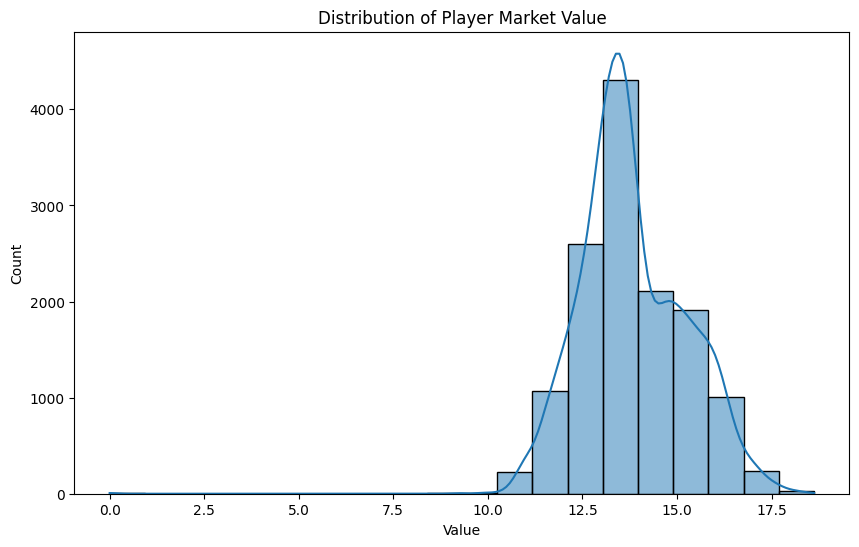

In [108]:
#disctribution of Player Market Value
plt.figure(figsize=(10, 6))
sns.histplot(data=outfield_df, x='Value', bins=20, kde=True)
plt.title('Distribution of Player Market Value')
plt.xlabel('Value')

Text(0.5, 0, 'Wage')

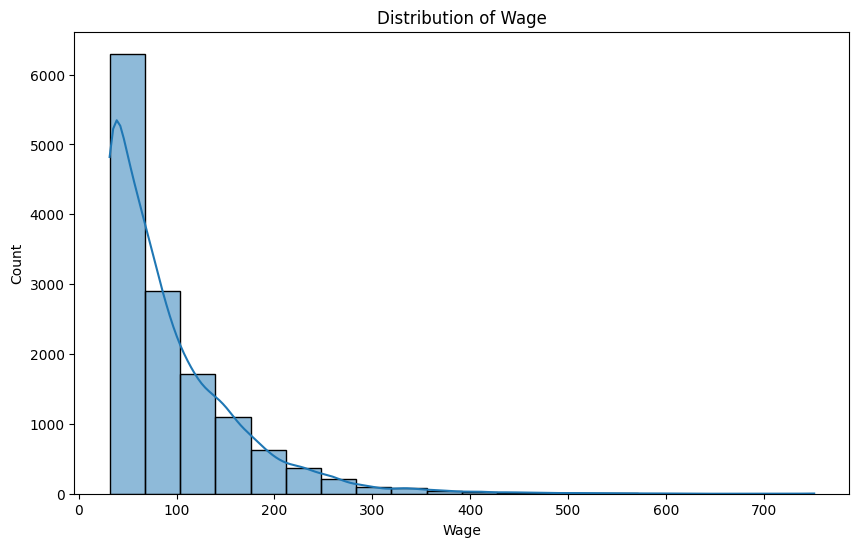

In [109]:
#distribution of wage
plt.figure(figsize=(10, 6))
sns.histplot(data=outfield_df, x='Wage', bins=20, kde=True)
plt.title('Distribution of Wage')
plt.xlabel('Wage')

Text(0.5, 0, 'Potential Score')

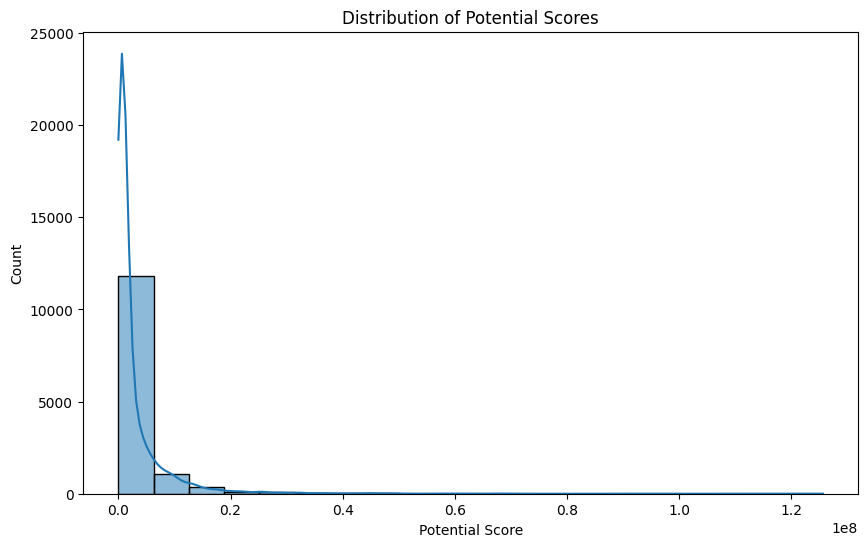

In [110]:
#Distribution of Potential
plt.figure(figsize=(10, 6))
sns.histplot(data=outfield_df, x='Potential', bins=20, kde=True)
plt.title('Distribution of Potential Scores')
plt.xlabel('Potential Score')

Text(0.5, 0, 'Overall Score')

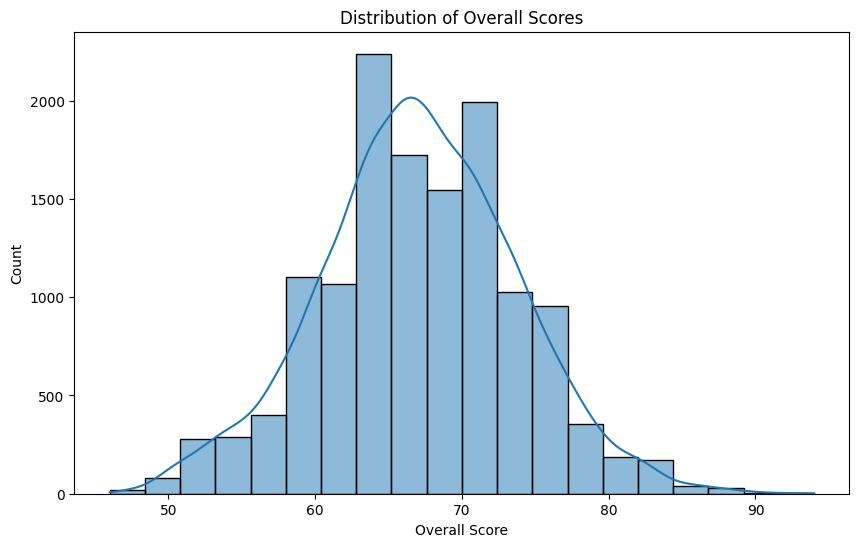

In [111]:
#distrbution of Overall
plt.figure(figsize=(10, 6))
sns.histplot(data=outfield_df, x='Overall', bins=20, kde=True)
plt.title('Distribution of Overall Scores')
plt.xlabel('Overall Score')

### Best teams in the league - clubs with most players rated over 85

<ipython-input-112-96bee098fce8>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels = number_of_players.index, rotation='vertical')


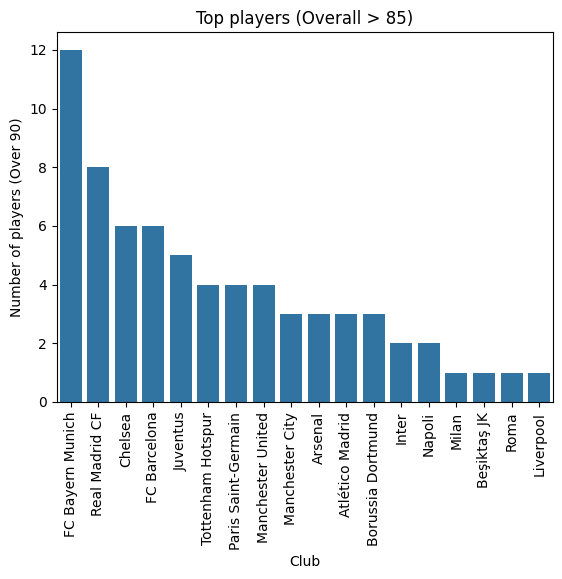

In [112]:
cutoff = 85
players = df[df['Overall']>cutoff]
grouped_players = df[df['Overall']>cutoff].groupby('Club')
number_of_players = grouped_players.count()['Name'].sort_values(ascending = False)

ax = sns.countplot(x = 'Club', data = players, order = number_of_players.index)

ax.set_xticklabels(labels = number_of_players.index, rotation='vertical')
ax.set_ylabel('Number of players (Over 90)')
ax.set_xlabel('Club')
ax.set_title('Top players (Overall > %.i)' %cutoff)
plt.show()

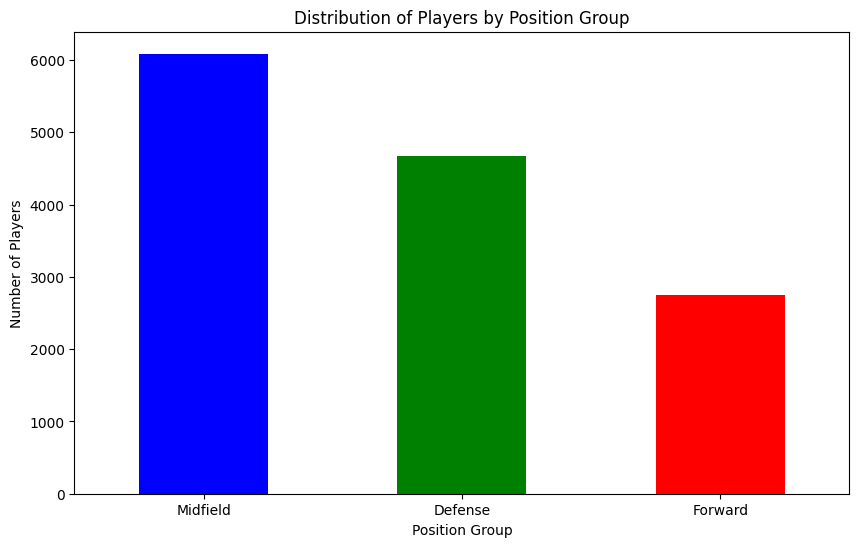

In [117]:
# Define a mapping for the positions
position_map = {
    'ST': 'Forward', 'CF': 'Forward', 'RW': 'Forward', 'LW': 'Forward', 'CAM': 'Midfield',
    'LM': 'Midfield', 'RM': 'Midfield', 'CM': 'Midfield', 'CDM': 'Midfield','CAM':'Midfield',
    'CB': 'Defense', 'LB': 'Defense', 'RB': 'Defense', 'LWB': 'Defense', 'RWB': 'Defense'
}

# Example: Assuming 'Preferred Position' is the column containing player positions
# Map each position to the appropriate group
outfield_df['Position_Group'] = outfield_df['Preferred Positions'].map(position_map)

# Count the number of players in each group
position_distribution = outfield_df['Position_Group'].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 6))
position_distribution.plot(kind='bar', color=['blue', 'green', 'red'])
plt.title('Distribution of Players by Position Group')
plt.xlabel('Position Group')
plt.ylabel('Number of Players')
plt.xticks(rotation=0)
plt.show()


Majority of the players in the Dataset are Midfields

In [118]:
# Distribution of countries in dataset
print(outfield_df.Nationality.value_counts())


Nationality
England              1279
Germany               949
Spain                 824
France                797
Argentina             703
                     ... 
Eritrea                 1
Somalia                 1
Kuwait                  1
St Kitts Nevis          1
Brunei Darussalam       1
Name: count, Length: 158, dtype: int64


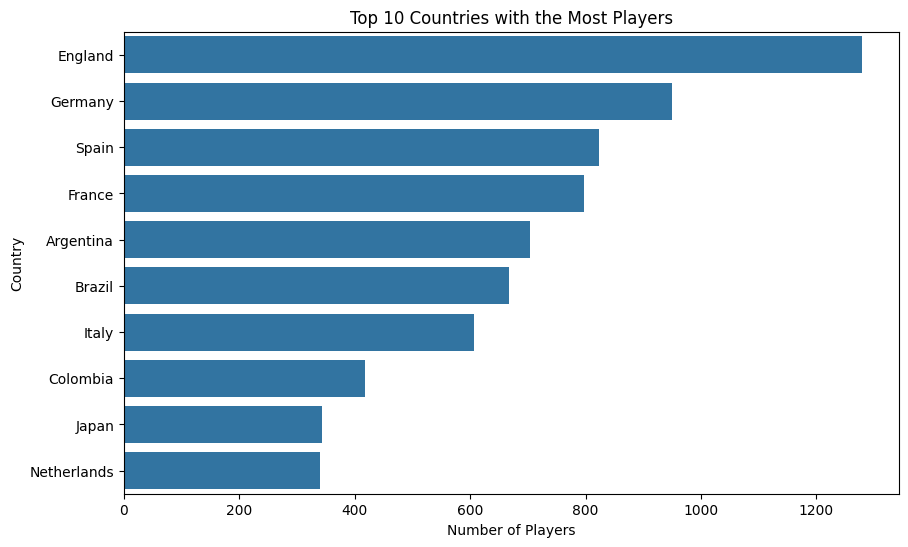

In [119]:
#visualizing top 10 countries
plt.figure(figsize=(10, 6))
sns.countplot(data=outfield_df, y='Nationality', order=outfield_df['Nationality'].value_counts().head(10).index)  # Top 10 countries
plt.title('Top 10 Countries with the Most Players')
plt.xlabel('Number of Players')
plt.ylabel('Country')
plt.show()

Majority of the players in the dataset were from Germany (indicated Germany as Nationality)

Top 10 countries with majority players in dataset

Germany
Spain
France
Argentina
Brazil
Italy
Colombia
Netherlands
Japan
Portugal

In [123]:
!pip install pycountry_convert
import pycountry_convert as pc
# Function to convert country to continent
def country_to_continent(country_name):
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except KeyError:
        return None

# Apply the function to the Nationality column to create a new Continent column
outfield_df['Continent'] = outfield_df['Nationality'].apply(country_to_continent)

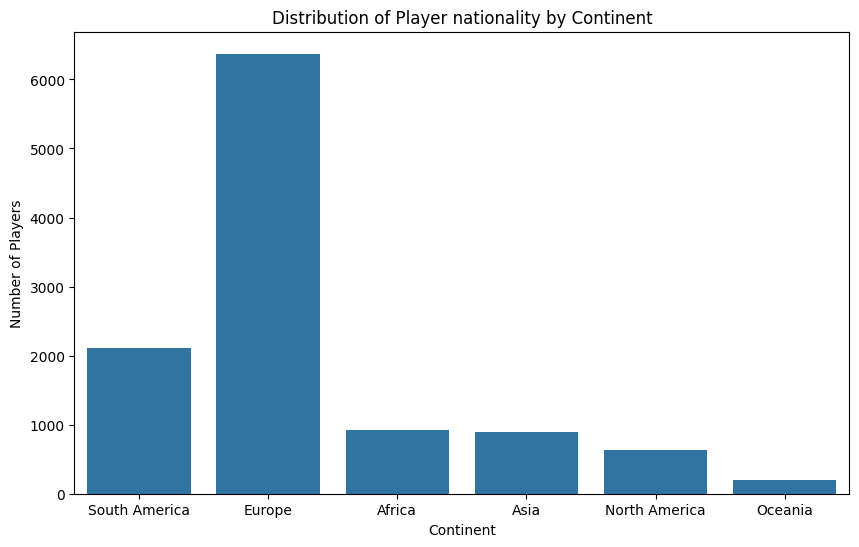

In [124]:
#distribution of players by continent
plt.figure(figsize=(10, 6))
sns.countplot(data=outfield_df, x='Continent')
plt.title('Distribution of Player nationality by Continent')
plt.xlabel('Continent')
plt.ylabel('Number of Players')
plt.show()

Majority of the players in the dataset are European

#**BIVARIATE ANALYSIS**


### plotting growth potential overall against age

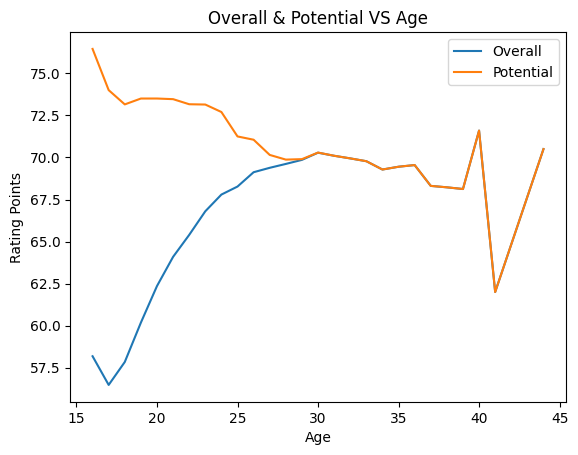

In [125]:
# fifa_growth = fifa.groupby(['Age'])['Growth'].mean()
fifa_overall = df.groupby(['Age'])['Overall'].mean()
fifa_potential = df.groupby(['Age'])['Potential'].mean()

summary = pd.concat([fifa_overall, fifa_potential], axis=1)

axis = summary.plot()
axis.set_ylabel('Rating Points')
axis.set_title('Overall & Potential VS Age')
plt.savefig('summary.png')

Let's explore Value against Overall rating

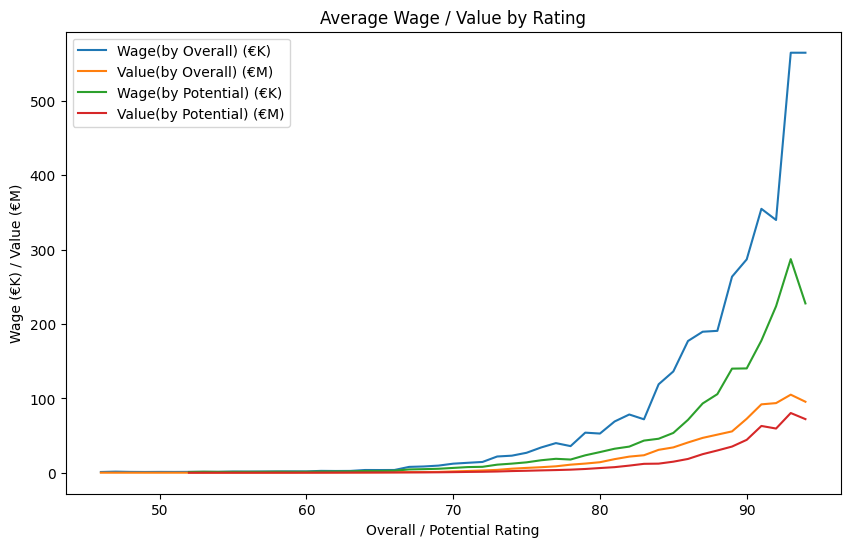

In [126]:
def extract_value_from(value):
    out = value.replace('€', '')
    if 'M' in out:
        out = float(out.replace('M', ''))*1000000
    elif 'K' in value:
        out = float(out.replace('K', ''))*1000
    return float(out)

df['Value'] = df['Value'].apply(lambda x: extract_value_from(x))
df['Wage'] = df['Wage'].apply(lambda x: extract_value_from(x))

# Group by 'Overall' and calculate mean Wage and Value
df_wage = df.groupby(['Overall'])['Wage'].mean()
df_value = df.groupby(['Overall'])['Value'].mean()

# Convert units: Wage in thousands (€K), Value in millions (€M)
df_wage = df_wage.apply(lambda x: x / 1000)
df_value = df_value.apply(lambda x: x / 1000000)

# Create new columns for wage and value by 'Potential'
df["Wage(by Potential)"] = df["Wage"]
df["Value(by Potential)"] = df["Value"]

# Group by 'Potential' and calculate mean Wage and Value
df_wage_p = df.groupby(['Potential'])['Wage(by Potential)'].mean()
df_value_p = df.groupby(['Potential'])['Value(by Potential)'].mean()

# Convert units: Wage in thousands (€K), Value in millions (€M)
df_wage_p = df_wage_p.apply(lambda x: x / 1000)
df_value_p = df_value_p.apply(lambda x: x / 1000000)

# Combine into summary table
summary = pd.concat([df_wage, df_value, df_wage_p, df_value_p], axis=1)
summary.columns = ['Wage(by Overall) (€K)', 'Value(by Overall) (€M)', 'Wage(by Potential) (€K)', 'Value(by Potential) (€M)']

# Plot summary
axis = summary.plot(figsize=(10, 6))
axis.set_ylabel('Wage (€K) / Value (€M)')
axis.set_xlabel('Overall / Potential Rating')
axis.set_title('Average Wage / Value by Rating')

# Save the plot
plt.savefig('summary.png')
plt.show()


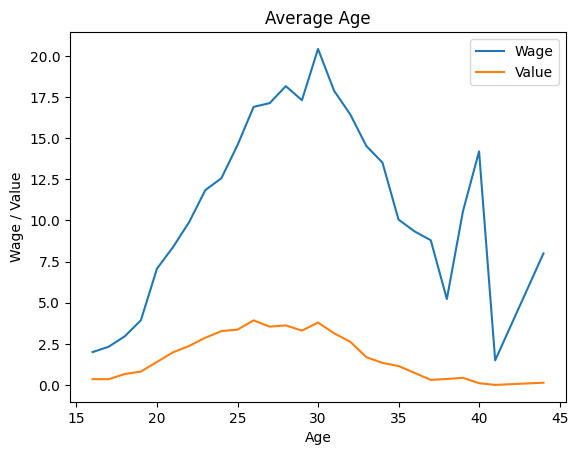

In [127]:
fifa_wage_a = df.groupby(['Age'])['Wage'].mean()
fifa_value_a = df.groupby(['Age'])['Value'].mean()
fifa_wage_a = fifa_wage_a.apply(lambda x: x/1000)
fifa_value_a = fifa_value_a.apply(lambda x: x/1000000)
summary1 = pd.concat([fifa_wage_a, fifa_value_a], axis=1)

axis = summary1.plot()
axis.set_ylabel('Wage / Value')
axis.set_title('Average Age')
plt.savefig('savefig.png')

### Prospect distribution

These clubs have the most young talents or developing players who have not yet reached their full potential.

These are the clubs with the greatest potential in the squad based on your filtering criteria.

**Plot below shows clubs with the most high-potential players.**

<ipython-input-129-1bbc85e10b8e>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best = outfield_df[(df['Potential'] >= thr) & (outfield_df['Overall'] < 70)]
<ipython-input-129-1bbc85e10b8e>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count_by_club.index[:20], y=count_by_club.values[:20], palette='viridis')


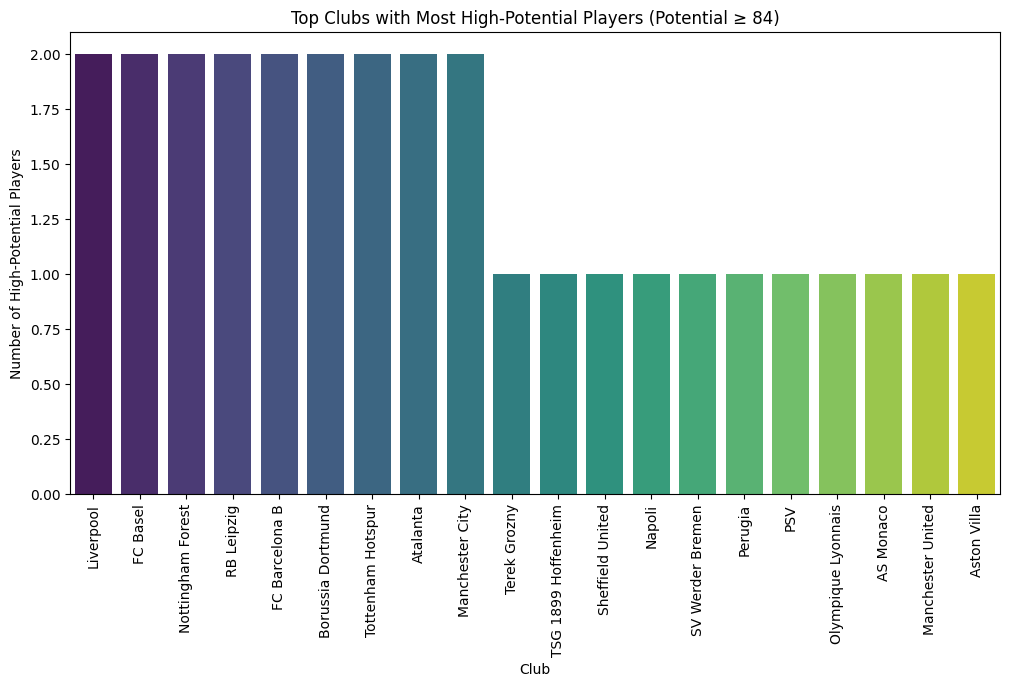

In [129]:
# Define the threshold for high potential
thr = 84

# Filter players with high potential but not yet elite overall rating
best = outfield_df[(df['Potential'] >= thr) & (outfield_df['Overall'] < 70)]

# Group by club and count high-potential players
count_by_club = best.groupby('Club')['Name'].count().sort_values(ascending=False)

# Group by club and sum total potential
total_potential_by_club = best.groupby('Club')['Potential'].sum().sort_values(ascending=False)

# Group by club and calculate average potential of the squad
avg_potential_by_club = df.groupby('Club')['Potential'].mean().sort_values(ascending=False)

# Plot: Count of high-potential players per club
plt.figure(figsize=(12, 6))
sns.barplot(x=count_by_club.index[:20], y=count_by_club.values[:20], palette='viridis')
plt.xticks(rotation='vertical')
plt.ylabel('Number of High-Potential Players')
plt.xlabel('Club')
plt.title(f'Top Clubs with Most High-Potential Players (Potential ≥ {thr})')
plt.show()



**Plot Highlights clubs with the highest total squad potential, meaning they have a lot of developing talent**

<ipython-input-130-460b45295222>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=total_potential_by_club.index[:20], y=total_potential_by_club.values[:20], palette='magma')


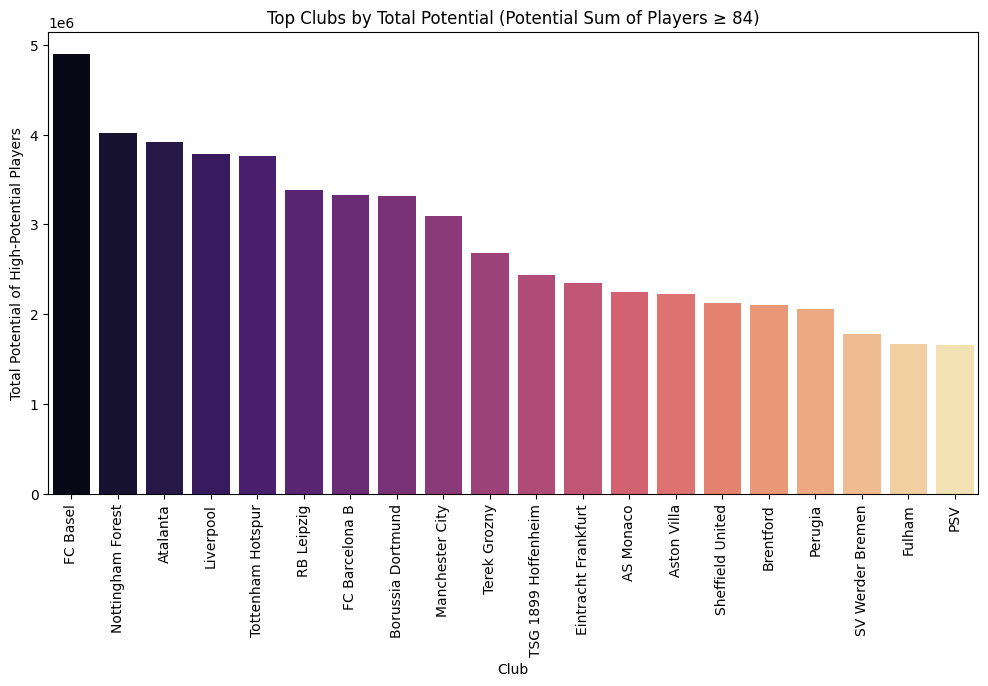

In [130]:
# Plot: Total squad potential per club
plt.figure(figsize=(12, 6))
sns.barplot(x=total_potential_by_club.index[:20], y=total_potential_by_club.values[:20], palette='magma')
plt.xticks(rotation='vertical')
plt.ylabel('Total Potential of High-Potential Players')
plt.xlabel('Club')
plt.title(f'Top Clubs by Total Potential (Potential Sum of Players ≥ {thr})')
plt.show()



**Identifies clubs with the highest average potential, meaning they consistently recruit strong talents.**

<ipython-input-131-31f78f6f4f3b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_potential_by_club.index[:20], y=avg_potential_by_club.values[:20], palette='coolwarm')


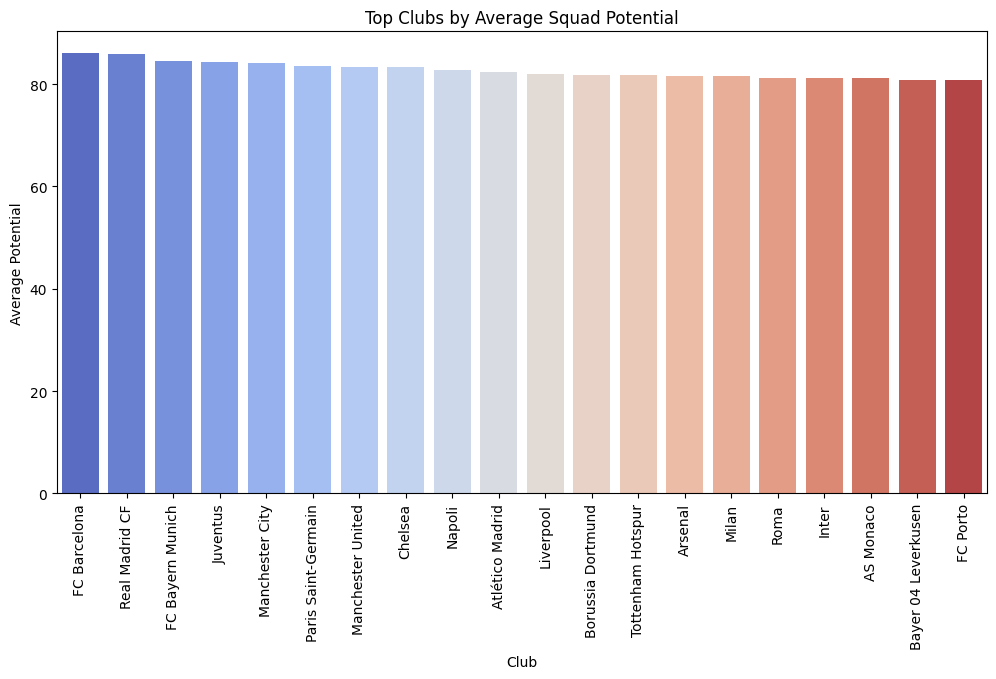

In [131]:
# Plot: Average squad potential per club
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_potential_by_club.index[:20], y=avg_potential_by_club.values[:20], palette='coolwarm')
plt.xticks(rotation='vertical')
plt.ylabel('Average Potential')
plt.xlabel('Club')
plt.title('Top Clubs by Average Squad Potential')
plt.show()


<ipython-input-132-4f0bc491b086>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  young_best =outfield_df[(outfield_df['Potential'] >= thr) & (outfield_df['Overall'] < thr) & (df['Age'] <= max_age)]
<ipython-input-132-4f0bc491b086>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  young_best['Position Group'] = young_best['Preferred Positions'].apply(lambda x: map_position(x.split()[0]))


<Figure size 1400x700 with 0 Axes>

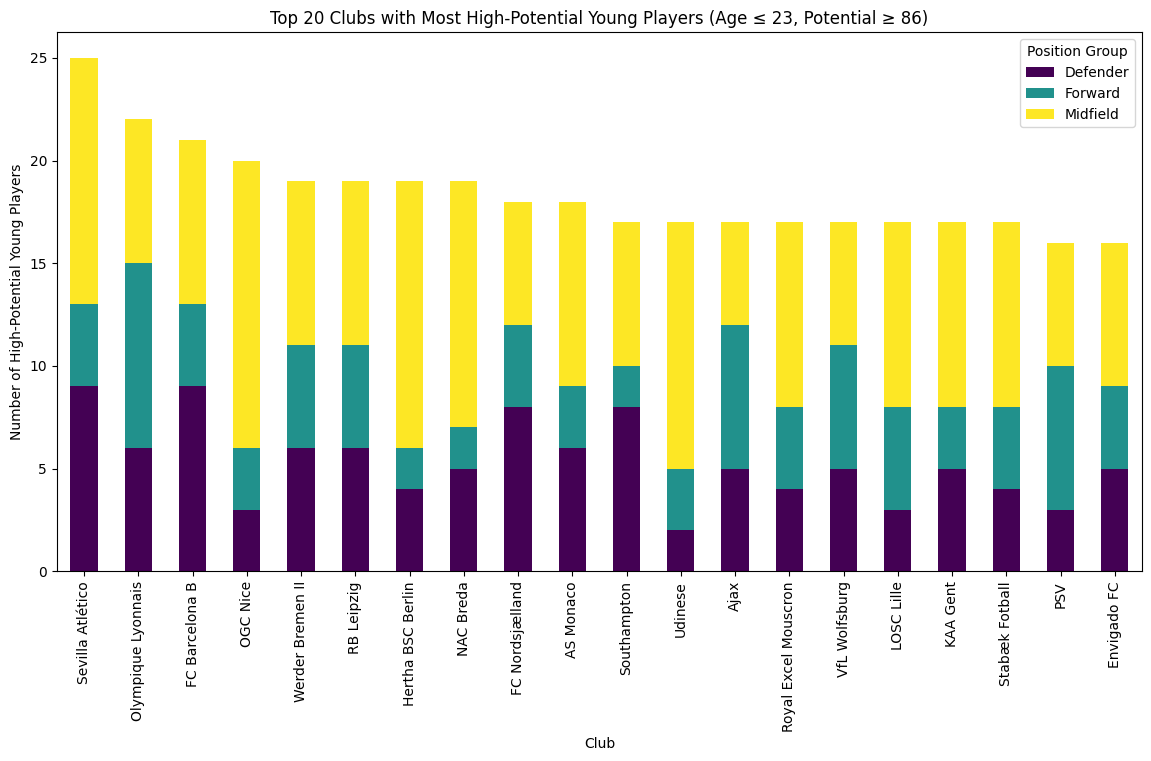

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define filters
thr = 86  # High potential threshold
max_age = 23  # Maximum age for young talents

# Filter young high-potential players
young_best =outfield_df[(outfield_df['Potential'] >= thr) & (outfield_df['Overall'] < thr) & (df['Age'] <= max_age)]

# Grouped position categories
forwards = ['ST', 'RW', 'LW', 'CF']
midfields = ['CAM', 'CM', 'CDM', 'LM', 'RM']
defenders = ['LWB', 'LB', 'CB', 'RB', 'RWB']


# Function to classify positions
def map_position(pos):
    if pos in forwards:
        return 'Forward'
    elif pos in midfields:
        return 'Midfield'
    elif pos in defenders:
        return 'Defender'
    else:
        return 'Other'

# Apply position mapping
young_best['Position Group'] = young_best['Preferred Positions'].apply(lambda x: map_position(x.split()[0]))

# Group by club and position, counting young high-potential players
club_position_count = young_best.groupby(['Club', 'Position Group'])['Name'].count().unstack().fillna(0)

# Sort by total young high-potential players
club_position_count['Total'] = club_position_count.sum(axis=1)
club_position_count = club_position_count.sort_values(by='Total', ascending=False).head(20)

# Plot grouped bar chart
plt.figure(figsize=(14, 7))
club_position_count.drop(columns=['Total']).plot(kind='bar', stacked=True, figsize=(14, 7), colormap='viridis')
plt.xticks(rotation='vertical')
plt.ylabel('Number of High-Potential Young Players')
plt.xlabel('Club')
plt.title(f'Top 20 Clubs with Most High-Potential Young Players (Age ≤ {max_age}, Potential ≥ {thr})')
plt.legend(title="Position Group")
plt.show()


Value Per League

In [133]:
team_league_map = {
    "LALIGA_1_2_3": [
        "AD Alcorcón",
        "Albacete Bpie",
        "CA Osasuna",
        "Cádiz CF",
        "CD Lugo",
        "CD Numancia",
        "CD Tenerife",
        "CF Reus",
        "Córdoba CF",
        "Cultural Leonesa",
        "FC Barcelona 'B'",
        "Granada CF",
        "Lorca FC",
        "Nàstic",
        "R. Oviedo",
        "R. Sporting",
        "R. Valladolid CF",
        "R. Zaragoza",
        "Rayo Vallecano",
        "SD Huesca",
        "Sevilla Atlético",
        "UD Almería"
    ],
    "EFL_League_One": [
        "AFC Wimbledon",
        "Blackburn Rovers",
        "Blackpool",
        "Bradford City",
        "Bristol Rovers",
        "Bury",
        "Charlton Ath",
        "Doncaster",
        "Fleetwood Town",
        "Gillingham",
        "MK Dons",
        "Northampton",
        "Oldham Athletic",
        "Oxford United",
        "Peterborough",
        "Plymouth Argyle",
        "Portsmouth",
        "Rochdale",
        "Rotherham Utd",
        "Scunthorpe Utd",
        "Shrewsbury",
        "Southend United",
        "Walsall",
        "Wigan Athletic"
    ],
    "EFL_League_Two": [
        "Accrington",
        "Barnet",
        "Cambridge Utd",
        "Carlisle United",
        "Cheltenham Town",
        "Chesterfield",
        "Colchester",
        "Coventry City",
        "Crawley Town",
        "Crewe Alexandra",
        "Exeter City",
        "Forest Green",
        "Grimsby Town",
        "Lincoln City",
        "Luton Town",
        "Mansfield Town",
        "Morecambe",
        "Newport County",
        "Notts County",
        "Port Vale",
        "Stevenage",
        "Swindon Town",
        "Wycombe",
        "Yeovil Town"
    ],
    "ALKA_SUPERLIGA": [
        "Aalborg BK",
        "Aarhus GF",
        "AC Horsens",
        "Brøndby IF",
        "FC Helsingør",
        "FC København",
        "FC Midtjylland",
        "FC Nordsjælland",
        "Hobro IK",
        "Lyngby BK",
        "Odense BK",
        "Randers FC",
        "Silkeborg IF",
        "SønderjyskE"
    ],
    "Belgian_Pro_League": [
        "Club Brugge KV",
        "Royal Excel Mouscron",
        "K.A.A. Gent",
        "K.A.S. Eupen",
        "K.R.C. Genk",
        "K.V. Kortrijk",
        "K.V. Mechelen",
        "K.V. Oostende",
        "Royal Antwerp FC",
        "R.S.C. Anderlecht",
        "Sint-Truidense V.V.",
        "Sporting Charleroi",
        "Sporting Lokeren",
        "Standard de Liège",
        "Waasland-Beveren",
        "S.V. Zulte Waregem"
    ],
    "LIGA_DO_BRASIL": [
        "Atl. Paranaense",
        "Atlético Mineiro",
        "Atlético-GO",
        "Avaí",
        "Botafogo",
        "Chapecoense",
        "Coritiba",
        "Cruzeiro",
        "Fluminense",
        "Grêmio",
        "Palmeiras",
        "Ponte Preta",
        "Santos",
        "São Paulo",
        "Sport",
        "Vitória"
    ],
    "EREDIVISIE": [
        "ADO Den Haag",
        "Ajax",
        "AZ",
        "Excelsior",
        "FC Groningen",
        "FC Twente",
        "FC Utrecht",
        "Feyenoord",
        "Heracles Almelo",
        "NAC Breda",
        "PEC Zwolle",
        "PSV",
        "Roda JC",
        "SC Heerenveen",
        "Sparta Rotterdam",
        "Vitesse",
        "VVV-Venlo",
        "Willem II"
    ],
    "PREMIER_LEAGUE": [
        "Arsenal",
        "Bournemouth",
        "Brighton",
        "Burnley",
        "Chelsea",
        "Crystal Palace",
        "Everton",
        "Huddersfield",
        "Leicester City",
        "Liverpool",
        "Manchester City",
        "Manchester Utd",
        "Newcastle Utd",
        "Southampton",
        "Spurs",
        "Stoke City",
        "Swansea City",
        "Watford",
        "West Brom",
        "West Ham"
    ],
    "EFL_Championship": [
        "Aston Villa",
        "Barnsley",
        "Birmingham City",
        "Bolton",
        "Brentford",
        "Bristol City",
        "Burton Albion",
        "Cardiff City",
        "Derby County",
        "Fulham",
        "Hull City",
        "Ipswich",
        "Leeds United",
        "Middlesbrough",
        "Millwall",
        "Norwich",
        "Nott’m Forest",
        "Preston",
        "QPR",
        "Reading",
        "Sheffield Utd",
        "Sheffield Wed",
        "Sunderland",
        "Wolves"
    ],
    "Ligue_2": [
        "AC Ajaccio",
        "AJ Auxerre",
        "ASNL",
        "AS Nancy-Lorraine",
        "Bourg en Bresse",
        "Football Bourg-en-Bresse",
        "Chamois FC",
        "Clermont Foot",
        "FC Lorient",
        "FCSM",
        "FC Sochaux-Montbéliard",
        "Gazélec Ajaccio",
        "Havre AC",
        "La Berrichonne",
        "Nîmes Olympique",
        "Paris FC",
        "Quevilly Rouen",
        "RC Lens",
        "Stade Brestois",
        "Stade de Reims",
        "Tours FC",
        "US Orléans",
        "Valenciennes FC"
    ],
    "Germany_3_Liga": [
        "1. FC Magdeburg",
        "FC Carl Zeiss Jena",
        "Chemnitzer FC",
        "SC Fortuna Köln",
        "FSV Zwickau",
        "Hallescher FC",
        "FC Hansa Rostock",
        "Karlsruher SC",
        "SC Preußen Münster",
        "FC Rot-Weiß Erfurt",
        "SG Sonnenhof Großaspach",
        "SC Paderborn 07",
        "Sportfreunde Lotte",
        "SV Meppen 1912",
        "SV Wehen Wiesbaden",
        "SpVgg Unterhaching",
        "VfL Osnabrück",
        "VfR Aalen",
        "SV Werder Bremen II",
        "FC Würzburger Kickers"
    ],
    "Bundesliga_2": [
        "FC Erzgebirge Aue",
        "Arminia Bielefeld",
        "VfL Bochum",
        "Eintracht Braunschweig",
        "SV Darmstadt 98",
        "Dynamo Dresden",
        "MSV Duisburg",
        "Fortuna Düsseldorf",
        "SpVgg Greuther Fürth",
        "1. FC Heidenheim 1846",
        "FC Ingolstadt 04",
        "1. FC Kaiserslautern",
        "Holstein Kiel",
        "1. FC Nürnberg",
        "SSV Jahn Regensburg",
        "SV Sandhausen",
        "FC St. Pauli",
        "1. FC Union Berlin"
    ],
    "LIGUE_1_CONFORAMA": [
        "Amiens SC",
        "Angers SCO",
        "AS Monaco",
        "AS Saint-Étienne",
        "Dijon FCO",
        "EA Guingamp",
        "ESTAC Troyes",
        "FC Metz",
        "FC Nantes",
        "Girondins de Bx",
        "LOSC Lille",
        "Montpellier HSC",
        "OGC Nice",
        "Olympique Lyon",
        "Olympique Marseille",
        "Paris Saint-Germain",
        "RC Strasbourg",
        "SM Caen",
        "Stade Rennais",
        "Toulouse FC",
        "FC Girondins de Bordeaux"
    ],
    "BUNDESLIGA": [
        "1. FC Köln",
        "1. FSV Mainz 05",
        "Bayer Leverkusen",
        "FC Bayern München",
        "Borussia Dortmund",
        "Borussia M'gladbach",
        "Borussia Mönchengladbach",
        "Eintracht Frankfurt",
        "FC Augsburg",
        "FC Schalke 04",
        "Hamburger SV",
        "Hannover 96",
        "Hertha BSC",
        "RB Leipzig",
        "RedBull Liepzig",
        "SC Freiburg",
        "SV Werder Bremen",
        "TSG Hoffenheim",
        "VfB Stuttgart",
        "VfL Wolfsburg"
    ],
    "Serie_A": [
        "Atalanta Bergamasca Calcio",
        "Benevento Calcio",
        "Bologna Football Club 1909",
        "Cagliari Calcio",
        "Associazione Calcio Chievo Verona",
        "Football Club Crotone",
        "ACF Fiorentina",
        "Fiorentina",
        "Genoa",
        "Hellas Verona",
        "FC Internazionale Milano",
        "Inter Milan",
        "Juventus Football Club",
        "SS Lazio",
        "Lazio",
        "Associazione Calcio Milan",
        "AC Milan",
        "Società Sportiva Calcio Napoli",
        "Napoli",
        "Associazione Sportiva Roma",
        "AS Roma",
        "Unione Calcio Sampdoria",
        "Sampdoria",
        "Unione Sportiva Sassuolo Calcio",
        "Sassuolo",
        "Società Polisportiva Ars et Labor",
        "SPAL",
        "Torino Football Club",
        "Torino",
        "Udinese Calcio"
    ],
    "Serie_B": [
        "Ascoli",
        "Avellino",
        "Bari",
        "Brescia",
        "Carpi",
        "Cesena",
        "Virtus Entella",
        "Chiavari",
        "Cittadella",
        "Cremonese",
        "Empoli",
        "Foggia",
        "Frosinone",
        "Spezia",
        "Novara",
        "Palermo",
        "Parma",
        "Perugia",
        "Pescara",
        "Salernitana",
        "Salerno",
        "Ternana",
        "Terni",
        "Venezia",
        "Pro Vercelli",
        "Vercelli"
    ],
    "Brasileirao_Serie_A": [
        "Club Athletico Paranaense",
        "Clube Atlético Mineiro",
        "Atlético Clube Goianiense",
        "Avaí Futebol Clube",
        "Botafogo de Futebol e Regatas",
        "Associação Chapecoense de Futebol",
        "Coritiba Foot Ball Club",
        "Cruzeiro Esporte Clube",
        "Fluminense Football Club",
        "Grêmio Foot-Ball Porto Alegrense",
        "Sociedade Esportiva Palmeiras",
        "Associação Atlética Ponte Preta",
        "Santos Futebol Clube",
        "São Paulo Futebol Clube",
        "Sport Club do Recife",
        "Esporte Clube Vitória"
    ],
    "Meiji_Yasuda_J1": [
        "Albirex Niigata",
        "Cerezo Osaka",
        "F.C. Tokyo",
        "Gamba Osaka",
        "H.Consa.Sapporo",
        "Júbilo Iwata",
        "Kashima Antlers",
        "Kashiwa Reysol",
        "Kawasaki-F",
        "Omiya Ardija",
        "S-Hiroshima",
        "Sagan Tosu",
        "Shimizu S-Pulse",
        "Urawa Reds",
        "Vegalta Sendai",
        "Ventforet Kofu",
        "Vissel Kobe",
        "Yokohama F･M"
    ],
    "K_LEAGUE_Classic": [
        "Daegu FC",
        "FC Seoul",
        "Gangwon FC",
        "GwangJu FC",
        "Incheon United",
        "Jeju United",
        "Jeonbuk Hyundai",
        "Jeonnam Dragons",
        "Pohang Steelers",
        "Sangju Sangmu",
        "Suwon Samsung",
        "Ulsan Hyundai"
    ],
    "Liga_MX": [
        "Club América",
        "Atlas FC",
        "Cruz Azul",
        "Club Deportivo Guadalajara",
        "Chivas",
        "Club León",
        "Lobos BUAP",
        "Monarcas Morelia",
        "CF Monterrey",
        "Rayados",
        "Club Necaxa",
        "CF Pachuca",
        "Club Puebla",
        "Querétaro FC",
        "Club Santos Laguna",
        "Tigres UANL",
        "Club Tijuana",
        "Xolos",
        "Deportivo Toluca FC",
        "Pumas UNAM",
        "Tiburones Rojos de Veracruz",
        "Veracruz"
    ],
    "Eredivisie": [
        "ADO Den Haag",
        "AFC Ajax",
        "Ajax",
        "AZ Alkmaar",
        "SBV Excelsior",
        "FC Groningen",
        "FC Twente",
        "FC Utrecht",
        "Feyenoord Rotterdam",
        "Heracles Almelo",
        "NAC Breda",
        "PEC Zwolle",
        "PSV Eindhoven",
        "Roda JC Kerkrade",
        "Roda JC",
        "SC Heerenveen",
        "Sparta Rotterdam",
        "Vitesse Arnhem",
        "VVV-Venlo",
        "Willem II Tilburg"
    ],
    "Eliteserien": [
        "Aalesunds FK",
        "FK Haugesund",
        "Kristiansund",
        "Lillestrøm SK",
        "Molde FK",
        "Odds BK",
        "Rosenborg BK",
        "Sandefjord",
        "Sarpsborg 08 FF",
        "SK Brann",
        "Sogndal Fotball",
        "Stabæk Fotball",
        "Strømsgodset IF",
        "Tromsø IL",
        "Vålerenga Fotball",
        "Viking FK"
    ],
    "Ekstraklasa": [
        "Arka Gdynia",
        "Cracovia",
        "Górnik Zabrze",
        "Jagiellonia",
        "Korona Kielce",
        "Lech Poznań",
        "Lechia Gdańsk",
        "Legia Warszawa",
        "Piast Gliwice",
        "Pogoń Szczecin",
        "Sandecja",
        "Śląsk Wrocław",
        "Termalica",
        "Wisła Kraków",
        "Wisła Płock",
        "Zagłębie Lubin"
    ],
    "Liga_NOS": [
        "Belenenses",
        "Boavista",
        "Chaves",
        "Estoril Praia",
        "F. Santa Maria",
        "FC Porto",
        "Marítimo",
        "Moreirense",
        "Paços Ferreira",
        "Portimão",
        "Rio Ave",
        "SC Braga",
        "SL Benfica",
        "Sporting CP",
        "Tondela",
        "V. Guimarães",
        "V. Setúbal",
        "Vila das Aves"
    ],
    "LA_LIGA": [
        "Alavés",
        "Athletic Club",
        "Atlético Madrid",
        "FC Barcelona",
        "'Real Betis Balompié'",
        "Celta Vigo",
        "Deportivo Alavés",
        "Deportivo La Coruña",
        "Eibar",
        "Espanyol",
        "Getafe",
        "Girona",
        "Las Palmas",
        "Leganés",
        "Levante",
        "Málaga",
        "Real Madrid CF",
        "Real Sociedad",
        "Sevilla",
        "Valencia",
        "Villarreal"
    ],
    "Russian_Premier_League": [
        "Amkar Perm",
        "FC Anzhi Makhachkala",
        "FC Arsenal Tula",
        "PFC CSKA Moscow",
        "FC Dynamo Moscow",
        "FC Akhmat Grozny",
        "FC Krasnodar",
        "FC Rostov",
        "FC Lokomotiv Moscow",
        "FC Rubin Kazan",
        "FC SKA-Khabarovsk",
        "FC Spartak Moscow",
        "FC Tosno",
        "FC Ufa",
        "FC Ural Yekaterinburg",
        "FC Zenit Saint Petersburg"
    ],
    "SSE_Airtricity_League": [
        "Bohemian FC",
        "Bray Wanderers",
        "Cork City",
        "Derry City",
        "Drogheda United",
        "Dundalk",
        "Finn Harps",
        "Galway United",
        "Limerick FC",
        "Shamrock Rovers",
        "Sligo Rovers",
        "St. Pats"
    ],
    "Dawry_Jameel": [
        "Al Ahli",
        "Al Batin",
        "Al Faisaly",
        "Al Fateh",
        "Al Fayha",
        "Al Hilal",
        "Al Ittihad",
        "Al Nassr",
        "Al Qadisiyah",
        "Al Raed",
        "Al Shabab",
        "Al Taawoun",
        "Ettifaq FC",
        "Ohod Club"
    ],
    "Scottish_Prem": [
        "Aberdeen",
        "Celtic",
        "Dundee FC",
        "Hamilton",
        "Hearts",
        "Hibernian",
        "Kilmarnock",
        "Motherwell",
        "Partick Thistle",
        "Rangers",
        "Ross County",
        "St. Johnstone"
    ],
    "Allsvenskan": [
        "AFC Eskilstuna",
        "AIK",
        "BK Häcken",
        "Djurgårdens IF",
        "GIF Sundsvall",
        "Halmstads BK",
        "Hammarby IF",
        "IF Elfsborg",
        "IFK Göteborg",
        "IFK Norrköping",
        "IK Sirius",
        "J-Södra",
        "Kalmar FF",
        "Malmö FF",
        "Örebro SK",
        "Östersunds FK"
    ],
    "Raffeisen Super League": [
        "BSC Young Boys",
        "FC Basel",
        "FC Lausanne-Sport",
        "FC Lugano",
        "FC Luzern",
        "FC Sion",
        "FC St. Gallen",
        "FC Thun",
        "FC Zürich",
        "Grasshopper Club"
    ],
    "Super_Lig": [
        "Akhisar Belediyespor",
        "Alanyaspor",
        "Antalyaspor",
        "İstanbul Başakşehir FK",
        "Beşiktaş JK",
        "Bursaspor",
        "Fenerbahçe SK",
        "Galatasaray SK",
        "Gençlerbirliği SK",
        "Göztepe SK",
        "Kardemir Karabükspor",
        "Kasımpaşa SK",
        "Kayserispor",
        "Konyaspor",
        "Osmanlıspor FK",
        "Sivasspor",
        "Trabzonspor",
        "Yeni Malatyaspor"
    ],
    "MAJOR LEAGUE SOCCER": [
        "Atlanta United",
        "Chicago Fire",
        "Colorado Rapids",
        "Columbus Crew SC",
        "D.C. United",
        "FC Dallas",
        "Houston Dynamo",
        "LA Galaxy",
        "Minnesota United",
        "Montreal Impact",
        "New England Revolution",
        "New York City FC",
        "New York Red Bulls",
        "Orlando City SC",
        "Philadelphia Union",
        "Portland Timbers",
        "Real Salt Lake",
        "San Jose Earthquakes",
        "Seattle Sounders",
        "Sporting KC",
        "Toronto FC",
        "Vancouver Whitecaps"
    ],
    "CHINESE SUPER LEAGUE": [
        "Beijing Guoan",
        "Changchun Yatai",
        "Chongqing Dangdai",
        "Guangzhou Evergrande",
        "Guangzhou R&F",
        "Guizhou Hengfeng",
        "Hebei China Fortune",
        "Henan Jianye",
        "Jiangsu Suning",
        "Liaoning FC",
        "Shandong Luneng",
        "Shanghai Greenland",
        "Shanghai SIPG",
        "Tianjin Quanjian",
        "Tianjin TEDA",
        "Yanbian Fude"
    ]
}


In [134]:
# Install necessary libraries (run once in Jupyter Notebook)
!pip install fuzzywuzzy
!pip install python-Levenshtein  # Optional but speeds up fuzzy matching

# Import required modules
import pandas as pd
from fuzzywuzzy import process  # Ensure this is imported

# Function to find the best match for each club
def match_club(club_name, club_list):
    if pd.isna(club_name) or club_name == 'Unknown':
        return None  # Handle missing values safely
    best_match = process.extractOne(club_name, club_list)
    return best_match[0] if best_match and best_match[1] > 80 else None  # Adjust threshold if needed

# Flatten the list of clubs from team_league_map
all_clubs = [club for clubs in team_league_map.values() for club in clubs]


# Fill NaNs before applying fuzzy matching
df['Club'] = df['Club'].fillna('Unknown')

# Apply fuzzy matching
df['Standardized_Club'] = df['Club'].apply(lambda x: match_club(str(x), all_clubs))

# Reverse map: Club -> League
club_to_league = {club: league for league, clubs in team_league_map.items() for club in clubs}

# Map clubs to leagues using the corrected names
df['League'] = df['Standardized_Club'].map(club_to_league)

# Display results
print(df)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 40.8 MB/s eta 0:00:00
       Unnamed: 0      ID                                           Photo  \
0               0  158023  https://cdn.sofifa.org/players/4/18/158023.png   
1               1   20801   https://cdn.sofifa.org/players/4/18/20801.png   
2               2  190871  https://cdn.sofifa.org/players/4/18/190871.png   
3               3  176580  https://cdn.sofifa.org/players/4/18/176580.png   
4               4  167495  https://cdn.sofifa.org/players/4/18/167495.png   
...           ...     ...                                             ...   
15400       15400  238219  https://cdn.sofifa.org/players/4/18/238219.png   
15401       15401  238477  https://cdn.sofifa.org/players/4/18/238477.png   
15402       15402  237974  https://cdn.sofifa.org/players/4/18/237974.png   
15403       15403  238813  https://cdn.sofifa.org/players/4/18/238813.png

In [135]:
league_country_map = {
    "PREMIER_LEAGUE": "England",
    "Serie_A": "Italy",
    "LA_LIGA": "Spain",
    "LIGUE_1_CONFORAMA": "France",
    "BUNDESLIGA": "Germany",
    "Ligue_2": "France",
    "Liga_NOS": "Portugal",
    "Russian_Premier_League": "Russia",
    "Super_Lig": "Turkey",
    "MAJOR LEAGUE SOCCER": "USA & Canada",
    "Bundesliga_2": "Germany",
    "Eredivisie": "Netherlands",
    "Liga_MX": "Mexico",
    "EFL_League_One": "England",
    "EREDIVISIE": "Netherlands",
    "LIGA_DO_BRASIL": "Brazil",
    "SSE_Airtricity_League": "Ireland",
    "Dawry_Jameel": "Saudi Arabia",
    "Raffeisen Super League": "Switzerland",
    "Belgian_Pro_League": "Belgium",
    "Meiji_Yasuda_J1": "Japan",
    "Brasileirao_Serie_A": "Brazil",
    "Allsvenskan": "Sweden",
    "LALIGA_1_2_3": "Spain",
    "EFL_Championship": "England",
    "Ekstraklasa": "Poland",
    "Scottish_Prem": "Scotland",
    "ALKA_SUPERLIGA": "Denmark",
    "Serie_B": "Italy",
    "Eliteserien": "Norway",
    "K_LEAGUE_Classic": "South Korea",
    "Germany_3_Liga": "Germany",
    "EFL_League_Two": "England"
}

#checks for name of the league and maps the country
df['Country'] =df['League'].map(league_country_map)

In [137]:
# Compute mean player value per league
league_mean_values = df.groupby('League')['Value'].mean()

print(league_mean_values)

League
ALKA_SUPERLIGA            7.636297e+05
Allsvenskan               8.931132e+05
BUNDESLIGA                7.982750e+06
Belgian_Pro_League        1.985528e+06
Brasileirao_Serie_A       1.953378e+06
Bundesliga_2              1.627053e+06
Dawry_Jameel              9.720871e+05
EFL_Championship          1.807635e+06
EFL_League_One            5.883826e+05
EFL_League_Two            2.995167e+05
EREDIVISIE                2.868799e+06
Ekstraklasa               7.662607e+05
Eliteserien               7.182258e+05
Eredivisie                2.025904e+06
Germany_3_Liga            4.626278e+05
K_LEAGUE_Classic          9.064978e+05
LALIGA_1_2_3              1.344109e+06
LA_LIGA                   8.871497e+06
LIGA_DO_BRASIL            2.446660e+06
LIGUE_1_CONFORAMA         5.479746e+06
Liga_MX                   2.295473e+06
Liga_NOS                  4.270340e+06
Ligue_2                   1.235370e+06
MAJOR LEAGUE SOCCER       1.889749e+06
Meiji_Yasuda_J1           7.182848e+05
PREMIER_LEAGUE    

**how the league affects player value.**

We compare the 'League' (categorical) with 'Value' (numerical).

a) **Top Leagues Have Lower Average Value Per Player:**

Serie A (6.22M), Premier League (6.77M), Bundesliga (6.32M), and La Liga (6.52M) **have the lowest average values.**

This is counterintuitive, as these are the most prestigious leagues.

**Why Do Top Leagues Have Low Averages?**

1. Top Leagues Have a Mix of High and Low-Value Players

  These leagues have superstars (high value) but also many low-value squad players, lowering the mean.

  Example: In the Premier League, superstars like Messi (if present) would be offset by youth players or backups.

2. Lower Leagues Have a More Homogeneous Player Value Distribution

  Leagues like Germany 3. Liga (19.22M) and K League (19.40M) show higher mean values, likely because:

  i.) Only the best players are included in FIFA 18.

  ii.) These leagues have fewer players, so the average skews higher.

  b) **Mid-Tier Leagues Have Moderate Values**

  EFL Championship (8.96M), Ligue 1 (8.80M), Liga NOS (8.57M)

  These leagues have decent players but fewer superstars.

  The values fall between top leagues and smaller leagues.




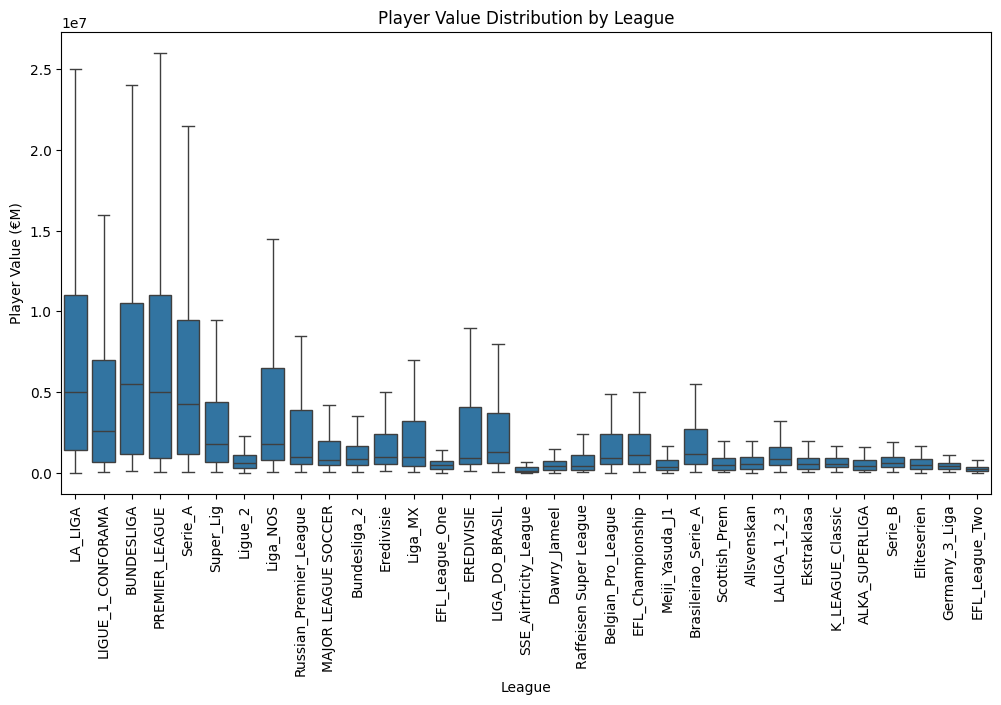

In [139]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['League'], y=df['Value'], showfliers=False)  # Remove outliers
plt.xticks(rotation=90)
plt.title("Player Value Distribution by League")
plt.ylabel("Player Value (€M)")
plt.xlabel("League")
plt.show()


Text(0, 0.5, 'Value Efficiency')

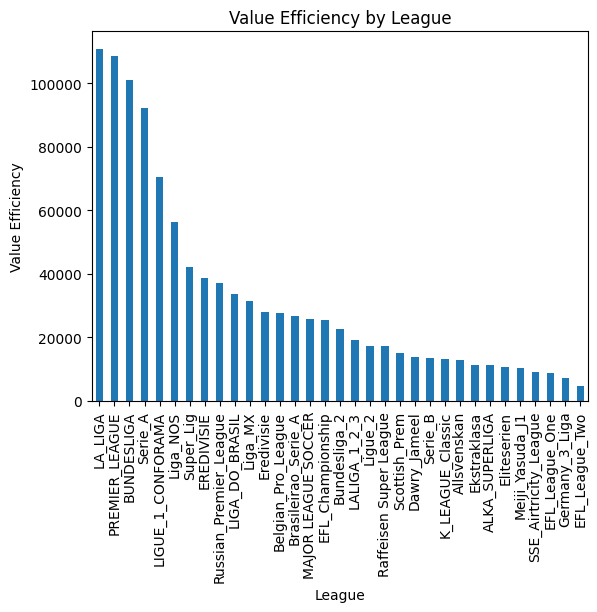

In [142]:
#Value_efficiency per league
df['Value_Efficiency'] = df['Value'] / df['Overall']
plot1=df.groupby('League')['Value_Efficiency'].mean().replace([float('inf'), -float('inf')], float('nan')).dropna().sort_values(ascending=False)
plot1.plot(kind='bar')
plt.title('Value Efficiency by League')
plt.xlabel('League')
plt.ylabel('Value Efficiency')


In [143]:
print(df.groupby('League')['Value_Efficiency'].mean().replace([float('inf'), -float('inf')], float('nan')).dropna().sort_values(ascending=False)

)


League
LA_LIGA                   110844.825772
PREMIER_LEAGUE            108771.057279
BUNDESLIGA                101050.870330
Serie_A                    92195.030911
LIGUE_1_CONFORAMA          70448.135751
Liga_NOS                   56247.371224
Super_Lig                  42209.196614
EREDIVISIE                 38868.094161
Russian_Premier_League     37299.035131
LIGA_DO_BRASIL             33605.618429
Liga_MX                    31380.887170
Eredivisie                 28117.345320
Belgian_Pro_League         27593.652451
Brasileirao_Serie_A        26902.816105
MAJOR LEAGUE SOCCER        25936.923136
EFL_Championship           25364.687909
Bundesliga_2               22747.863029
LALIGA_1_2_3               19175.598233
Ligue_2                    17380.613955
Raffeisen Super League     17175.768907
Scottish_Prem              15122.135734
Dawry_Jameel               13836.932300
Serie_B                    13442.606197
K_LEAGUE_Classic           13216.295565
Allsvenskan                12996.

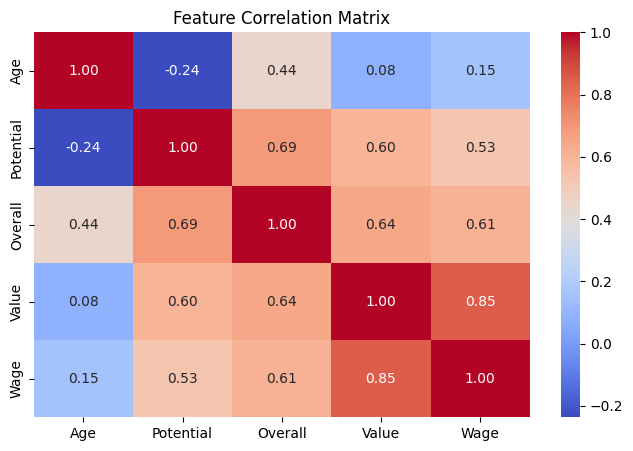

In [144]:
# Correlation heatmap
plt.figure(figsize=(8,5))
sns.heatmap(df[['Age', 'Potential', 'Overall', 'Value', 'Wage']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

##Modelling: Classification Problem

Model 1 : Simple Logistic Classifier

In [171]:
#defining our features
X = outfield_df[['Age', 'Potential', 'Overall', 'Wage']]
y = outfield_df['Hidden_Gem']

In [172]:
outfield_df.columns

Index(['ID', 'Name', 'Age', 'Nationality', 'Overall', 'Potential', 'Club',
       'Preferred Positions', 'Technical Attributes', 'Mental Attributes',
       'Physical Attributes', 'Defensive Attributes',
       'Total_Current_Attributes', 'Development_Potential', 'Growth_Rate',
       'Value_for_Money_Index', 'Market_Value_Efficiency', 'ROI',
       'Adjusted_VER', 'Hidden_Gem', 'Normalized_Attribute_Score', 'Value',
       'Wage', 'Age', 'Position_Group', 'Continent'],
      dtype='object')

Train-Test Split

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [174]:
#building the model and modelling
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Train Model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Model Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8733802295446131
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2347
           1       0.53      0.31      0.39       354

    accuracy                           0.87      2701
   macro avg       0.72      0.63      0.66      2701
weighted avg       0.85      0.87      0.86      2701



Class Imbalance: The model seems to favor the majority class (0), as shown by the high recall for class 0 (96%) and the lower recall for class 1 (31%).
Macro Avg: The macro average (unweighted average) metrics are lower for both precision and recall, showing that the model might not be performing equally well across both classes.

Logistic Regression model is performing well in terms of accuracy, with an overall score of 87.34%. However, looking at the classification report, we see some imbalance in performance between the two classes:

Precision for Class 1 (the minority class) is 0.53, which means that when the model predicts class 1, it is correct only 53% of the time.
Recall for Class 1 is 0.31, which indicates that the model is only correctly identifying 31% of the actual class 1 instances.
F1-Score for Class 1 is 0.39, suggesting a relatively low balance between precision and recall for this class.

###Checking for class imbalance

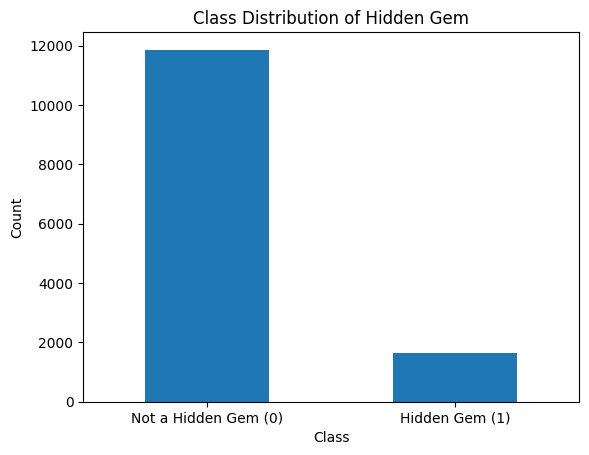

In [175]:
import matplotlib.pyplot as plt

# Check the distribution of the target variable 'Hidden_Gem'
y.value_counts().plot(kind='bar')
plt.title('Class Distribution of Hidden Gem')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Not a Hidden Gem (0)', 'Hidden Gem (1)'], rotation=0)
plt.show()


highly imbalance

1.Class Weighting in Logistic Regression:

Class weighting allows the model to give more importance to the minority class, balancing the performance between both classes.

In [176]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Logistic Regression with class weighting
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Model Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8063680118474639
              precision    recall  f1-score   support

           0       0.98      0.79      0.88      2347
           1       0.40      0.91      0.55       354

    accuracy                           0.81      2701
   macro avg       0.69      0.85      0.71      2701
weighted avg       0.91      0.81      0.83      2701



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


results show some improvement for class 1 (the minority class), with recall for class 1 increasing to 91%, meaning the model is now correctly identifying more of the actual class 1 instances. However, there are some trade-offs:

Precision for Class 1 is 0.40, which is lower compared to the previous result (0.53). This suggests that while the model is identifying more instances of class 1, many of those predictions are incorrect.

Recall for Class 0 dropped to 79%, which is lower than before, indicating that the model is now focusing more on class 1 but at the cost of class 0 performance.

Increase max_iter: You can increase the number of iterations to give the solver more time to converge.

**Feature Scaling**:

Logistic Regression benefits from scaling when the features vary significantly in magnitude. Use StandardScaler to scale your features before fitting the model.

In [177]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model with scaled features
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Model Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



Accuracy: 0.8330248056275453
              precision    recall  f1-score   support

           0       0.99      0.81      0.89      2347
           1       0.44      0.95      0.60       354

    accuracy                           0.83      2701
   macro avg       0.71      0.88      0.75      2701
weighted avg       0.92      0.83      0.86      2701



Precision for Class 1 still low

In [178]:
# Applying SMOTE to balance the classes
from imblearn.over_sampling import SMOTE  # For handling class imbalance
smote = SMOTE(sampling_strategy='auto', random_state=42)

#using new features
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Building the Logistic Regression model with class weights
model = LogisticRegression(random_state=42, max_iter=200)

model.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred = model.predict(X_test)

# Model Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8696778970751573
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      2347
           1       0.50      0.90      0.64       354

    accuracy                           0.87      2701
   macro avg       0.74      0.88      0.78      2701
weighted avg       0.92      0.87      0.88      2701



The results after applying SMOTE (Synthetic Minority Over-sampling Technique) show a noticeable improvement:

Recall for Class 1 is now 90%, which is very good. This shows that the model is identifying most of the class 1 instances.

Precision for Class 1 is 0.50, which is still lower but better than before. It means that for every 10 instances predicted as class 1, 5 are correct.

Recall for Class 0 is 86%, which is reasonable given that the model is balancing between both classes.

In [197]:
# Check for overfitting
# Evaluate the model on both training and testing data

# Evaluate on training data
y_train_pred = model.predict(X_train_scaled)

# Model evaluation on training data
print("Training Accuracy:", accuracy_score(y_train_resampled, y_train_pred))
print(classification_report(y_train_resampled, y_train_pred))

# Evaluation on test data
print("\nTest Set Evaluation:")
print(classification_report(y_test, y_pred))

# Confusion matrix for test data
cm = confusion_matrix(y_test, y_pred)

# Convert confusion matrix to DataFrame for better readability
import pandas as pd
cm_df = pd.DataFrame(cm, index=['Predicted: 0', 'Predicted: 1'], columns=['Actual: 0', 'Actual: 1'])

# Display the confusion matrix as a table
print("\nConfusion Matrix (Test Data):")
print(cm_df)


Training Accuracy: 0.6848328778642001
              precision    recall  f1-score   support

           0       0.64      0.85      0.73      9514
           1       0.78      0.52      0.62      9514

    accuracy                           0.68     19028
   macro avg       0.71      0.68      0.68     19028
weighted avg       0.71      0.68      0.68     19028


Test Set Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      2347
           1       0.71      0.97      0.82       354

    accuracy                           0.94      2701
   macro avg       0.85      0.96      0.89      2701
weighted avg       0.96      0.94      0.95      2701


Confusion Matrix (Test Data):
              Actual: 0  Actual: 1
Predicted: 0       2206        141
Predicted: 1         10        344


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Key Points from the Evaluation:

Training Precision (class 1): 0.78

Test Precision (class 1): 0.71

Even though the test precision is slightly lower than the training precision, it’s still decent, which indicates that the model is doing relatively well at identifying the positive class (Hidden Gems) among the prediction.

The model is likely being conservative in predicting class 1 (fewer false positives), which is good for precision.

**Adding more Feature**

 Consider creating new features that combine existing ones in meaningful ways, like the Value-to-Potential Ratio or a Performance-to-Value Ratio. These can offer additional insights:

In [199]:
outfield_df['Value_to_Potential'] = outfield_df['Value'] / outfield_df['Potential']
outfield_df['Performance_to_Value'] = outfield_df['Adjusted_VER'] / outfield_df['Value']


Categorize Age or Experience: If Age is relevant for your Hidden Gem definition, you could categorize players into age groups:

In [ ]:
outfield_df['Age_Group'] = pd.cut(outfield_df['Age'], bins=[18, 23, 27, 30, 35], labels=['18-23', '24-27', '28-30', '31+'])


 **2.Prepare Data for Modeling**

Feature Selection: Use a feature selection method (e.g., Random Forest or Lasso Regression) to identify which features contribute the most to predicting Hidden Gems.

Important Features:
                    Feature  Coefficient
0             Adjusted_VER    -1.815078
1  Market_Value_Efficiency     0.463976
2    Value_for_Money_Index     0.217079
3                    Value    -0.494901
4       Value_to_Potential    -0.980699
5     Performance_to_Value     1.931869

Training Accuracy: 0.8584652706843718

Classification Report - Training Data:
               precision    recall  f1-score   support

           0       0.98      0.73      0.84      7832
           1       0.78      0.99      0.87      7832

    accuracy                           0.86     15664
   macro avg       0.88      0.86      0.86     15664
weighted avg       0.88      0.86      0.86     15664


Test Accuracy: 0.788858939802336

Classification Report - Test Data:
               precision    recall  f1-score   support

           0       1.00      0.76      0.86      1941
           1       0.38      0.98      0.54       285

    accuracy                           0.79      2226
   

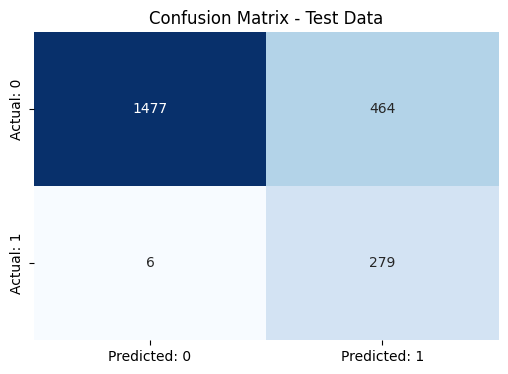

In [208]:

from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE  # For SMOTE
from imblearn.pipeline import Pipeline  # To apply SMOTE in a pipeline


# Split data
X = outfield_df[['Adjusted_VER', 'Market_Value_Efficiency', 'Value_for_Money_Index',
                 'Value', 'Value_to_Potential', 'Performance_to_Value']]
y = outfield_df['Hidden_Gem']

# Handle missing values in the features by imputing with the mean of each column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Apply SMOTE for class balancing on the training data
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# LassoCV for feature selection and training
lasso = LassoCV(cv=5, max_iter=10000)  # Removed solver argument
lasso.fit(X_train_resampled, y_train_resampled)

# Check the important features
important_features = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso.coef_
})

print("Important Features:\n", important_features)

# Evaluate the model on training data
y_train_pred = lasso.predict(X_train_resampled)
y_train_pred_binary = (y_train_pred > 0.5).astype(int)  # Convert regression output to binary classification

# Evaluate the model on testing data
y_test_pred = lasso.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

# Model Evaluation - Training Data
print("\nTraining Accuracy:", accuracy_score(y_train_resampled, y_train_pred_binary))
print("\nClassification Report - Training Data:\n", classification_report(y_train_resampled, y_train_pred_binary))

# Model Evaluation - Test Data
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred_binary))
print("\nClassification Report - Test Data:\n", classification_report(y_test, y_test_pred_binary))

# Display Confusion Matrix for Test Data
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)
print("\nConfusion Matrix - Test Data:\n", conf_matrix)

# Convert confusion matrix to a DataFrame for better readability
conf_matrix_df = pd.DataFrame(conf_matrix, index=["Actual: 0", "Actual: 1"], columns=["Predicted: 0", "Predicted: 1"])

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_df, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix - Test Data")
plt.show()


Class Imbalance: Although SMOTE was applied to balance the training data, the imbalance still affects the performance. The model shows excellent recall for the minority class (hidden gems), but precision suffers, leading to many false positives for class 1.

##Decision Tree

To improve performance, particularly in handling the class imbalance and providing more interpretable results, we have decided to move towards a Decision Tree model. A decision tree will:

Handle Class Imbalance Better: Decision trees can inherently handle class imbalance by focusing on splitting data based on the most informative features, making them more robust to imbalanced classes.

Provide Interpretability: Unlike logistic regression, decision trees are easy to visualize and interpret, helping to explain why certain features (e.g., Adjusted_VER, Market_Value_Efficiency, Value_for_Money_Index) are more important in predicting a player's potential as a hidden gem.

Improve Precision for Class 1: Decision trees will likely improve precision for the minority class (Hidden Gem) by better defining decision boundaries, which should lead to fewer false positives.

In [222]:
# 1. Data Preprocessing - Apply SMOTE for class balancing
smote = SMOTE(sampling_strategy='auto', random_state=42)

In [223]:
# Split data into features and target
X = outfield_df[['Age', 'Potential', 'Overall', 'Wage']]
y = outfield_df['Hidden_Gem']

In [224]:
# Apply SMOTE to the training set to handle class imbalance
X_resampled, y_resampled = smote.fit_resample(X, y)

In [225]:
#distribution of resampled
print(y_resampled.value_counts())


Hidden_Gem
0    9773
1    9773
Name: count, dtype: int64


In [226]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

#Training the classifier
dt.fit(X_train, y_train)

#Predicting
y_pred = dt.predict(X_test)



In [227]:
# Evaluate the model

# Accuracy on the test set
test_accuracy = dt.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

# Classification report for detailed metrics
print("Classification Report - Test Data:")
print(classification_report(y_test, y_pred))

# Confusion matrix to understand class distribution
print("Confusion Matrix - Test Data:")
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.9941176470588236
Classification Report - Test Data:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1942
           1       0.99      1.00      0.99      1968

    accuracy                           0.99      3910
   macro avg       0.99      0.99      0.99      3910
weighted avg       0.99      0.99      0.99      3910

Confusion Matrix - Test Data:
[[1928   14]
 [   9 1959]]


 a test accuracy of 99.4%, a high precision and recall for both classes, and a confusion matrix that shows very few misclassifications. However, the model appears to be overfitting, which is evident because the accuracy is extremely high.

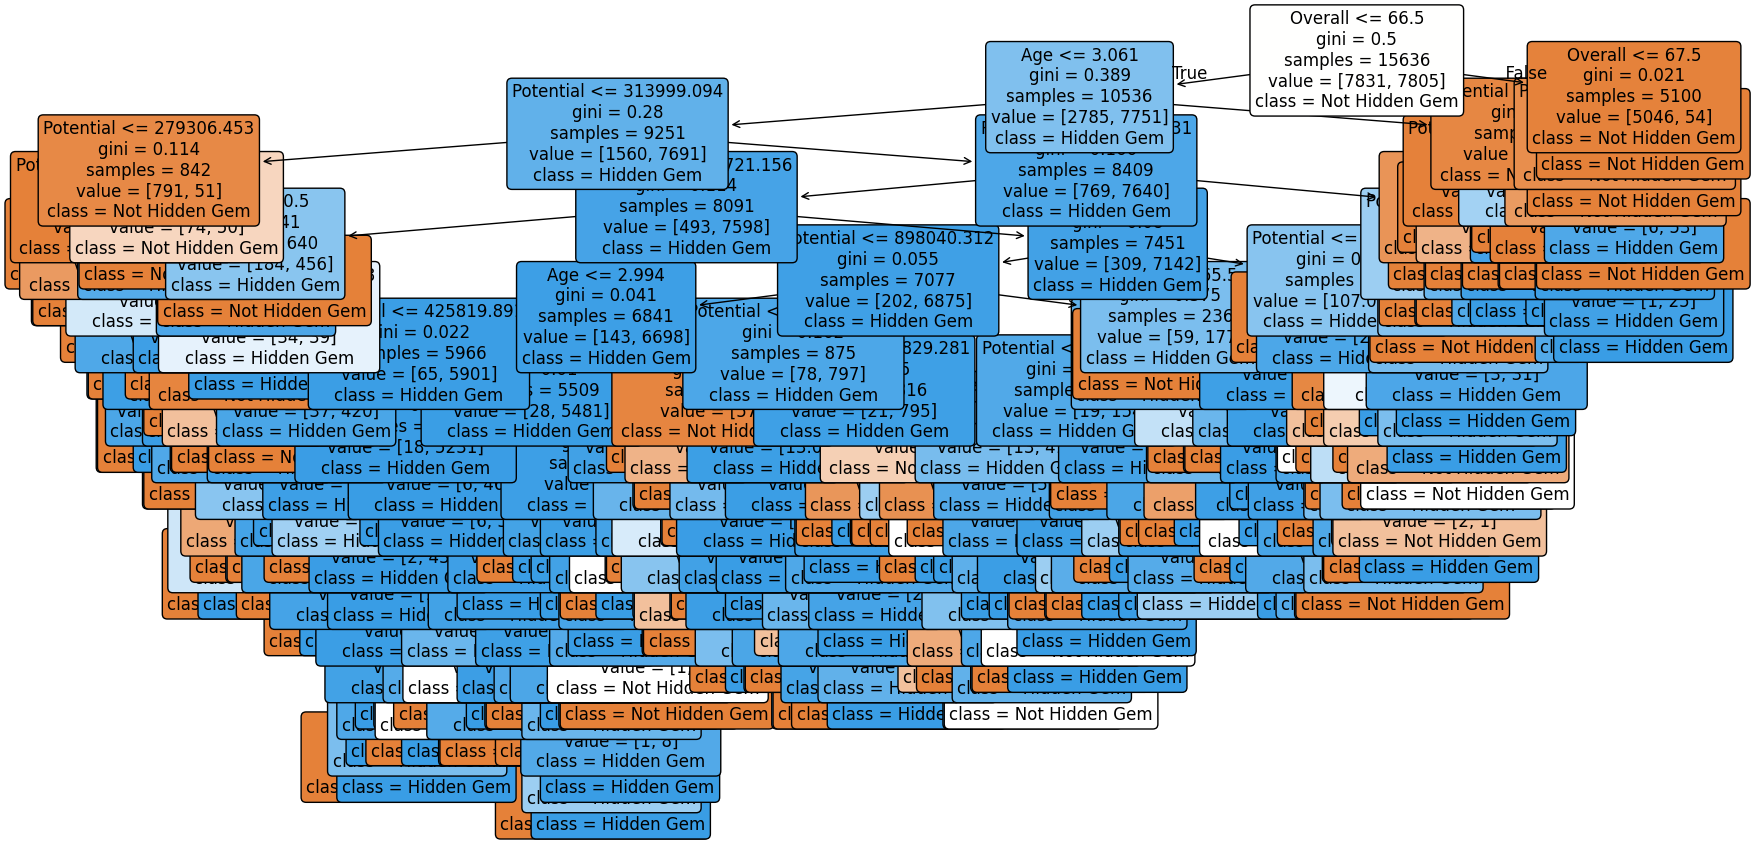

In [228]:
# Display the decision tree
plt.figure(figsize=(20,10))
plot_tree(dt, filled=True, feature_names=X.columns, class_names=['Not Hidden Gem', 'Hidden Gem'], rounded=True, fontsize=12)
plt.show()

Clear Case of Overfitting

Hyperparameter Tuning Using **GridSearchCV**

In [235]:
# Define hyperparameter grid
param_grid = {
    'max_depth': [1, 5, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_dt = grid_search.best_estimator_

# Display the best parameters
print(f"The best parameters found by GridSearchCV are: {best_params}")

# Evaluate the best model
y_pred_best = best_dt.predict(X_test)

# Print results for the best model
print("Test Accuracy (Best Model):", best_dt.score(X_test, y_test))
print("Classification Report - Test Data (Best Model):")
print(classification_report(y_test, y_pred_best))
print("Confusion Matrix - Test Data (Best Model):")
print(confusion_matrix(y_test, y_pred_best))



Fitting 5 folds for each of 54 candidates, totalling 270 fits
The best parameters found by GridSearchCV are: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test Accuracy (Best Model): 0.9941176470588236
Classification Report - Test Data (Best Model):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1942
           1       0.99      1.00      0.99      1968

    accuracy                           0.99      3910
   macro avg       0.99      0.99      0.99      3910
weighted avg       0.99      0.99      0.99      3910

Confusion Matrix - Test Data (Best Model):
[[1928   14]
 [   9 1959]]


In [236]:
# Configurable Parameters
# You can manually modify the values of the hyperparameters below:
manual_param_grid = {
    'max_depth': 4,  # Manually change max depth
    'min_samples_split': 2,  # Manually change min_samples_split
    'min_samples_leaf': 1,  # Manually change min_samples_leaf
    'criterion': 'gini'  # Manually change criterion
}

# Manually configuring the model with new parameters
manual_dt = DecisionTreeClassifier(**manual_param_grid)
manual_dt.fit(X_train, y_train)

# Evaluate the manually configured model
y_pred_manual = manual_dt.predict(X_test)
print("Test Accuracy (Manual Model):", manual_dt.score(X_test, y_test))
print("Classification Report - Test Data (Manual Model):")
print(classification_report(y_test, y_pred_manual))

Test Accuracy (Manual Model): 0.9636828644501279
Classification Report - Test Data (Manual Model):
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1942
           1       0.94      0.99      0.96      1968

    accuracy                           0.96      3910
   macro avg       0.97      0.96      0.96      3910
weighted avg       0.96      0.96      0.96      3910



The results from the grid search indicate that the Decision Tree is still performing excellently with test accuracy around 99.4%, and precision/recall for both classes are also very high. Even after tuning hyperparameters, the model's performance seems to remain strong, which could still be a sign of overfitting.

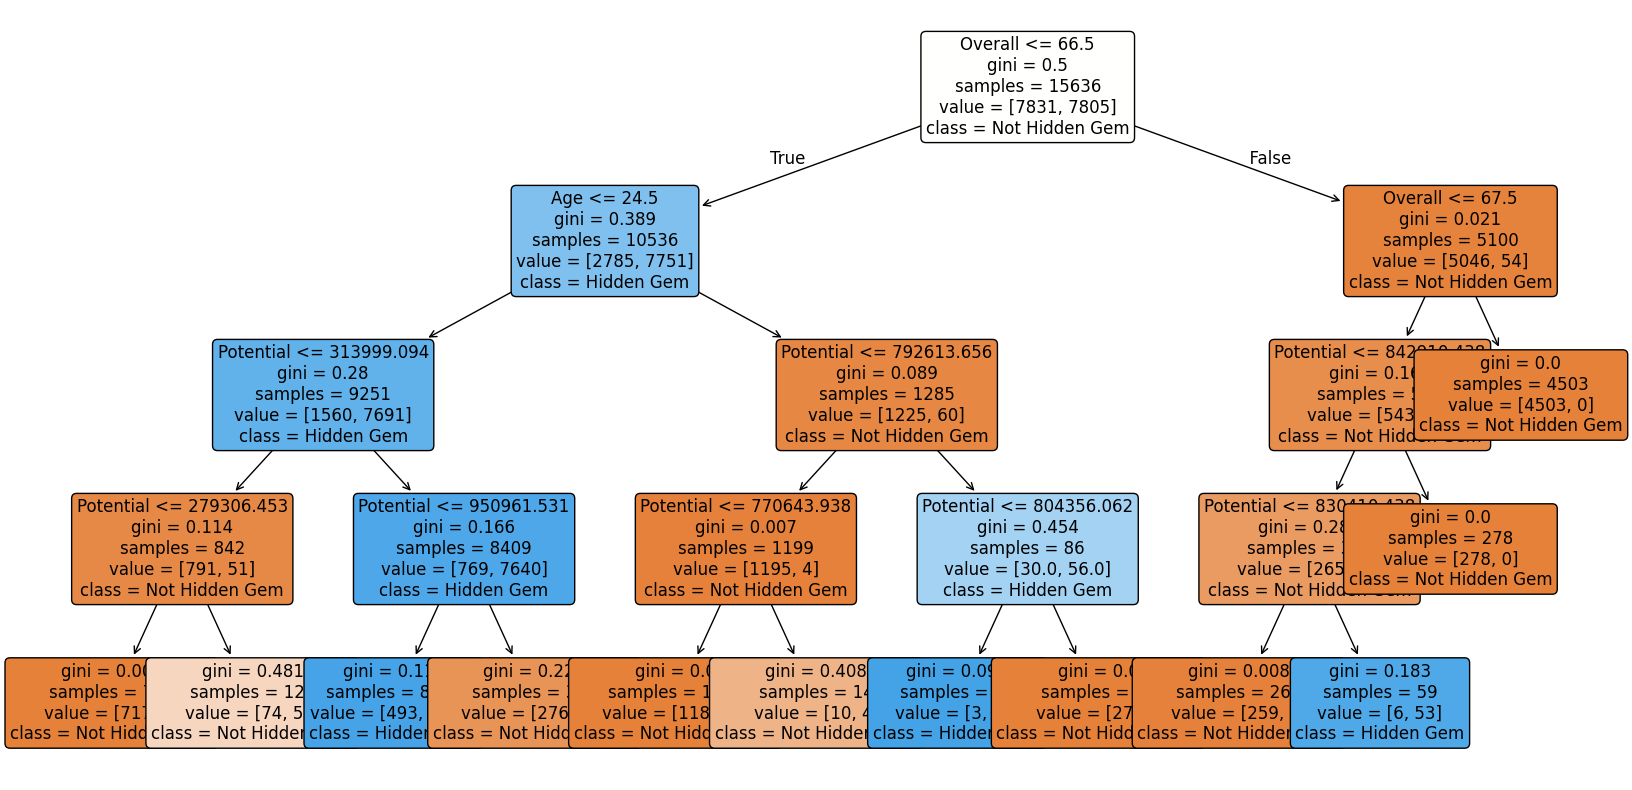

In [237]:
# Display the decision tree
plt.figure(figsize=(20,10))
plot_tree(manual_dt, filled=True, feature_names=X.columns, class_names=['Not Hidden Gem', 'Hidden Gem'], rounded=True, fontsize=12)
plt.show()

In [238]:
# Evaluate the model on the training set
train_accuracy = manual_dt.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy}")

# Evaluate the model on the test set (already calculated)
test_accuracy = manual_dt.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Print classification report for both training and test sets
print("Classification Report - Training Data:")
print(classification_report(y_train, manual_dt.predict(X_train)))

print("Classification Report - Test Data:")
print(classification_report(y_test, y_pred_manual))

# Compare the performance: High training accuracy but low test accuracy indicates overfitting


Training Accuracy: 0.9616270145817345
Test Accuracy: 0.9636828644501279
Classification Report - Training Data:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      7831
           1       0.94      0.99      0.96      7805

    accuracy                           0.96     15636
   macro avg       0.96      0.96      0.96     15636
weighted avg       0.96      0.96      0.96     15636

Classification Report - Test Data:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1942
           1       0.94      0.99      0.96      1968

    accuracy                           0.96      3910
   macro avg       0.97      0.96      0.96      3910
weighted avg       0.96      0.96      0.96      3910



The model is performing well on both training and test data, which indicates good generalization.

There’s no evidence of significant overfitting, as the accuracy and classification metrics are stable across both datasets.

It’s clear that the Decision Tree model has outperformed the Logistic Regression model, even after feature engineering in the logistic model.

**Random Forest**

Finally, let's improve the model by using Random Forest. We'll start with a base configuration and then tune it for better performance.

In [240]:
from sklearn.ensemble import RandomForestClassifier

#defining our features
X = outfield_df[['Age', 'Potential', 'Overall', 'Wage']]
y = outfield_df['Hidden_Gem']

# Split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Base Random Forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

# Model Evaluation for Random Forest
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
print("Confusion Matrix - Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))


Random Forest Accuracy: 0.9919137466307277
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1941
           1       0.97      0.97      0.97       285

    accuracy                           0.99      2226
   macro avg       0.98      0.98      0.98      2226
weighted avg       0.99      0.99      0.99      2226

Confusion Matrix - Random Forest:
[[1931   10]
 [   8  277]]


The model shows excellent performance, especially for class 0 (non-hidden gems), with very few false positives and high precision and recall.

Class 1 (hidden gems) also has solid performance with good precision, recall, and F1-score, although there is slightly more room for improvement in precision (compared to class 0).

The very low number of False Positives (FP) and False Negatives (FN) shows that the model is making accurate predictions overall.

Checking for Overfitting

In [241]:
# Training Accuracy
train_accuracy = rf.score(X_train, y_train)

# Compare with Test Accuracy
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_rf)}")


Training Accuracy: 0.9980901022357038
Test Accuracy: 0.9919137466307277


The comparison between Training Accuracy (99.81%) and Test Accuracy (99.19%) shows that the model is performing well on both the training and test sets.

The gap between the two accuracies is not very large, indicating that there isn't significant overfitting. However, the slight drop in test accuracy could still suggest some minor overfitting.

In [242]:
#using class_weights to deal with class imbalance

# Base Random Forest model with class weighting
rf_weighted = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42, class_weight='balanced')
rf_weighted.fit(X_train, y_train)

# Predictions
y_pred_rf_weighted = rf_weighted.predict(X_test)

# Model Evaluation for Random Forest with Class Weighting
print("Random Forest Accuracy (Weighted):", accuracy_score(y_test, y_pred_rf_weighted))
print("Classification Report (Weighted):")
print(classification_report(y_test, y_pred_rf_weighted))

# Confusion Matrix
print("Confusion Matrix - Random Forest (Weighted):")
print(confusion_matrix(y_test, y_pred_rf_weighted))


Random Forest Accuracy (Weighted): 0.9914645103324349
Classification Report (Weighted):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1941
           1       0.97      0.97      0.97       285

    accuracy                           0.99      2226
   macro avg       0.98      0.98      0.98      2226
weighted avg       0.99      0.99      0.99      2226

Confusion Matrix - Random Forest (Weighted):
[[1931   10]
 [   9  276]]


The Random Forest model with class weighting has performed well, showing a high accuracy of 99.15%. The precision, recall, and F1-score for the minority class (Hidden Gem = 1) are much better compared to the unweighted model.

Here are the key insights:

Precision for the minority class (Hidden Gem = 1) is 0.97, meaning the model is correctly identifying a high percentage of actual hidden gems.
Recall for Hidden Gem = 1 is also 0.97, indicating that the model is capturing almost all the hidden gems, which is crucial given the imbalance.

The confusion matrix confirms that the model is performing well with minimal false positives (10) and false negatives (9).

In [243]:
# To apply SMOTE (Synthetic Minority Over-sampling Technique), which helps in generating synthetic samples for the minority class
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Applying SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Base Random Forest model
rf_smote = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)

# Predictions
y_pred_rf_smote = rf_smote.predict(X_test)

# Model Evaluation for Random Forest with SMOTE
print("Random Forest with SMOTE Accuracy:", accuracy_score(y_test, y_pred_rf_smote))
print(classification_report(y_test, y_pred_rf_smote))

# Confusion Matrix
print("Confusion Matrix - Random Forest with SMOTE:")
print(confusion_matrix(y_test, y_pred_rf_smote))


Random Forest with SMOTE Accuracy: 0.9914645103324349
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1941
           1       0.95      0.98      0.97       285

    accuracy                           0.99      2226
   macro avg       0.97      0.99      0.98      2226
weighted avg       0.99      0.99      0.99      2226

Confusion Matrix - Random Forest with SMOTE:
[[1927   14]
 [   5  280]]


Key Precision Values:

Precision for Class 0 (majority class): 1.00

Precision for Class 1 (minority class): 0.95

Even though the recall for class 1 is very high (98%), the precision for the minority class (0.95) has decreased compared to the earlier model (around 0.97). The trade-off here is that we’ve improved the recall for class 1, but at the cost of precision.

Precision for class 0: This is already perfect at 1.00, meaning the model is highly reliable for predicting the majority class.

Precision for class 1: 0.95 is still strong, but it indicates that some of the predicted minority class instances (class 1) are actually false positives. This trade-off is typical when we use resampling techniques like SMOTE, which aims to better identify the minority class but might also increase false positives.

**Adjusting the Decision Threshold**:

We'll modify the threshold for predicting class 1 and check how precision changes.

In [244]:
from sklearn.metrics import precision_score

# Predict probabilities
y_pred_prob = rf.predict_proba(X_test)[:, 1]

# Adjust threshold (let's start with 0.6 for example)
threshold = 0.6
y_pred_adjusted = (y_pred_prob > threshold).astype(int)

# Evaluate precision for adjusted threshold
precision_adjusted = precision_score(y_test, y_pred_adjusted)
print("Precision with adjusted threshold:", precision_adjusted)

# Classification report and confusion matrix
print(classification_report(y_test, y_pred_adjusted))
print(confusion_matrix(y_test, y_pred_adjusted))


Precision with adjusted threshold: 0.9750889679715302
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1941
           1       0.98      0.96      0.97       285

    accuracy                           0.99      2226
   macro avg       0.98      0.98      0.98      2226
weighted avg       0.99      0.99      0.99      2226

[[1934    7]
 [  11  274]]


By adjusting the threshold, you've managed to achieve a precision of 0.975, which is impressive. The recall also improved slightly (0.96), meaning that fewer "hidden gems" are missed, and the f1-score remains high at 0.97.

Precision: 0.975 (a good boost from the previous value)

Recall: 0.96 (slightly improved)

F1-Score: 0.97 (maintained)

Accuracy: 0.99 (almost unchanged)

**Confusion Matrix**

True Negatives (TN): 1934 (Correctly predicted non-hidden gems)

False Positives (FP): 7 (Non-hidden gems incorrectly predicted as hidden gems)

False Negatives (FN): 11 (Hidden gems incorrectly predicted as non-hidden gems)

True Positives (TP): 274 (Correctly predicted hidden gems)

**Hyperparameter Tuning for Random Forest**

In [245]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20],
    'class_weight': ['balanced', 'balanced_subsample', None],
}

# Applying SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# GridSearch for hyperparameter tuning
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='precision', n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

# Best parameters
print("Best hyperparameters:", grid_search.best_params_)

# Use the best model from GridSearch
best_rf = grid_search.best_estimator_

# Evaluate the best model
y_pred_best = best_rf.predict(X_test)

# Model Evaluation
print("Precision after hyperparameter tuning:", precision_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))
print(confusion_matrix(y_test, y_pred_best))


Best hyperparameters: {'class_weight': 'balanced_subsample', 'max_depth': 20, 'n_estimators': 200}
Precision after hyperparameter tuning: 0.9491525423728814
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1941
           1       0.95      0.98      0.97       285

    accuracy                           0.99      2226
   macro avg       0.97      0.99      0.98      2226
weighted avg       0.99      0.99      0.99      2226

[[1926   15]
 [   5  280]]


#**RECOMMENDATIONS**

**1.Strategic Scouting Insights:**

Clustering simplified complex player data into actionable segments. It allowed us to pinpoint hidden gems and elite undervalued players while flagging overhyped, expensive options.By grouping players into clusters based on their age, overall attributes, potential, and market value, we uncover distinct segments that reveal hidden market inefficiencies.

 This segmentation directly informs our scouting strategy, ensuring that we invest our time and resources where the potential ROI is highest, ultimately supporting a data-driven approach to recruitment.

Distinct Player Profiles:

**Cluster 2 (Hidden Gems):**

These players show high potential and strong attributes but are available at a very low market value. This suggests they are undervalued investments—ideal targets for scouting and further evaluation.

**Cluster 0 (Elite Undervalued Players):**

Players in this group possess the highest attributes and potential, yet their market value remains low. This could indicate that, despite their elite performance, they are overlooked or mispriced, offering significant upside.

**Cluster 1 (Expensive Young Talents):**

Here, players command high market values despite lower attributes. They may be overhyped or driven by external factors rather than actual performance, indicating caution should be exercised.

**Cluster 3 (Established, High-Market Players):**

These are players with moderate potential but very high market value—likely veterans with significant brand or media influence rather than future growth potential.

**1.1 Scouting Focus**

a.) Focus on Undervalued Clusters:

 By targeting clusters 2 and 0, the club can allocate scouting resources to regions or leagues where undervalued talent is most common, increasing the likelihood of identifying high ROI signings.

b.) Avoid Overpriced Talent:

Clusters 1 and 3 signal that some players may be overvalued, suggesting that pursuing them could result in costly investments with lower future returns.

c.) Regional & League-Level Analysis:

Overlaying these clusters on geographic maps further identifies which leagues or regions consistently produce players from the undervalued clusters. This enables the club to set up scouting bases strategically in those hotspots.

**2.Identifying and Exploit Market Inefficiencies for Profit**

Some high-value players may be in "cheaper" leagues.
If a Serie A player is undervalued, clubs can target such leagues for recruitment.
Helps find hidden gems in lower-value leagues.

**3.Setting up Scouting Bases**

Setting up Scouting bases in this leagues could prove beneficial because of the high Value-Efficiency

Liga_NOS                  67.354738

EFL_Championship          66.552180

Brasileirao_Serie_A       64.174153

Eredivisie                63.808187

LIGA_DO_BRASIL            60.679394